In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling1D, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise, Embedding, multiply, concatenate, add
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.model_selection import train_test_split
from textwrap import wrap

In [3]:
tf.__version__

'2.1.0'

In [4]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [5]:
def load_image_caption_dict():
    caption_dict = None
    with open('./bert/embeddedcaptions.pickle', 'rb') as f:
        return pickle.load(f)
    
caption_dict = load_image_caption_dict()

def load_caption_text_dict():
    caption_dict = None
    with open('./bert/captions.pickle', 'rb') as f:
        return pickle.load(f)
    
caption_text_dict = load_caption_text_dict()

In [6]:
train_imgs = []
train_classes = []
train_captions = []
caption_text = []
class_index = 0
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned-named/", topdown=False):
    print(f'{len(files)} samples in class {class_index}, ({root})')
    for name in files:
        train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))
        train_classes.append(class_index)
        train_captions.append(caption_dict[name.split('.')[0]+'.txt'][0]) # Just using the first of 10 captions for now
        caption_text.append(caption_text_dict[name.split('.')[0]+'.txt'][0]) # Just using the first of 10 captions for now
    class_index += 1
train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5
train_imgs = train_imgs.astype(np.float32)
train_classes = np.array(train_classes)
train_captions = np.array(train_captions)

60 samples in class 0, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/001.Black_footed_Albatross)
60 samples in class 1, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/002.Laysan_Albatross)
58 samples in class 2, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/003.Sooty_Albatross)
60 samples in class 3, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/004.Groove_billed_Ani)
44 samples in class 4, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/005.Crested_Auklet)
41 samples in class 5, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/006.Least_Auklet)
53 samples in class 6, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/007.Parakeet_Auklet)
48 samples in class 7, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/008.Rhinoceros_Auklet)
59 samples in class 8, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/009.Brewer_Blackbird)
60 samples in class 9, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/010.Red_winged_Blackbird)
60 samples in class 10, (./CUB_200_2011/CUB_20

60 samples in class 86, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/087.Mallard)
60 samples in class 87, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/088.Western_Meadowlark)
60 samples in class 88, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/089.Hooded_Merganser)
60 samples in class 89, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/090.Red_breasted_Merganser)
60 samples in class 90, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/091.Mockingbird)
60 samples in class 91, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/092.Nighthawk)
60 samples in class 92, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/093.Clark_Nutcracker)
60 samples in class 93, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/094.White_breasted_Nuthatch)
60 samples in class 94, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/095.Baltimore_Oriole)
60 samples in class 95, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/096.Hooded_Oriole)
59 samples in class 96, (./CUB_200_2011/CUB_200_2

56 samples in class 177, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/178.Swainson_Warbler)
59 samples in class 178, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/179.Tennessee_Warbler)
60 samples in class 179, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/180.Wilson_Warbler)
59 samples in class 180, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/181.Worm_eating_Warbler)
60 samples in class 181, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/182.Yellow_Warbler)
60 samples in class 182, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/183.Northern_Waterthrush)
60 samples in class 183, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/184.Louisiana_Waterthrush)
60 samples in class 184, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/185.Bohemian_Waxwing)
60 samples in class 185, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/186.Cedar_Waxwing)
50 samples in class 186, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/187.American_Three_toed_Woodpecker)
60 samples

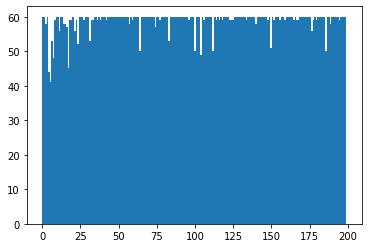

(11788, 64, 64, 3)


In [7]:
plt.hist(train_classes, bins=200)
plt.show()
assert(len(train_imgs) == len(train_classes))
print(train_imgs.shape)

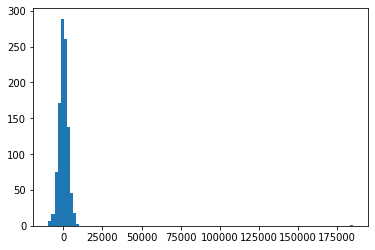

929
18.448483


In [8]:
plt.hist(np.sum(train_captions, axis=0), bins=100)
plt.show()
print(np.argmax(np.sum(train_captions, axis=0)))
print(train_captions[2786][929])

In [9]:
def create_simple_attrs(attrs):
    # Structure is like so: [0-14:color, 15-19:size, 20-33:shape]

    simple_attrs = np.zeros((attrs.shape[0], 34))
    
    # Color
    simple_attrs[:, 0:15] = attrs[:, 248:263]
    
    # Size and shape
    simple_attrs[:, 15:34] = attrs[:, 217:236]
    
    return simple_attrs


In [10]:
def create_even_simpler_attrs(attrs):
    # Structure is like so: [0-4:color, 5-7:size, 8-9:shape]
    
    simplest_attrs = np.zeros((attrs.shape[0], 10))
    
    simplest_attrs[:, 0] = attrs[:, 1] # Brown
    simplest_attrs[:, 1] = attrs[:, 5] # Grey
    simplest_attrs[:, 2] = attrs[:, 11] # Black
    simplest_attrs[:, 3] = attrs[:, 12] # White
    simplest_attrs[:, 4] = np.clip(np.sum(attrs[:, [0, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14]], axis=1), a_min=0, a_max=1) # Other
    
    simplest_attrs[:, 5] = attrs[:, 19] # Smallest
    simplest_attrs[:, 6] = attrs[:, 16] # Small
    simplest_attrs[:, 7] = np.clip(np.sum(attrs[:, [15, 17, 18]], axis=1), a_min=0, a_max=1) # Large
    
    simplest_attrs[:, 8] = attrs[:, 33] # Perching-like
    simplest_attrs[:, 9] = np.clip(np.sum(attrs[:, [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]], axis=1), a_min=0, a_max=1) # Not perching-like
    
    return simplest_attrs

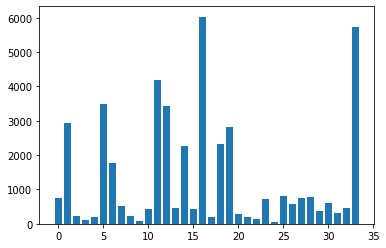

In [11]:
def load_image_attributes():
    train_attrs = np.zeros((train_imgs.shape[0], 312))
    with open('./CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            
            # For now we don't care about attribute certainty, just if it is present.
            try:
                split = line.split()
                img_id = int(split[0])
                assert(img_id > 0)
                assert(img_id <= 11788)
                attr_id = int(split[1])
                assert(attr_id > 0)
                assert(attr_id <= 312)
                is_present = int(split[2])
                assert(is_present == 0 or is_present == 1)
            except: 
                print(line)
                print(line.split())
                return
            
            train_attrs[img_id-1, attr_id-1] = is_present
    return train_attrs

train_attrs = load_image_attributes().astype('float32')
train_attrs = create_simple_attrs(train_attrs)
plt.bar([x for x in range(34)], np.sum(train_attrs, axis=0))
plt.show()
# train_attrs = create_even_simpler_attrs(train_attrs)
train_attrs = train_attrs.astype(np.float32)

In [14]:
def make_caption_autoencoder(attribute_shape):
    caption_shape = 1024
    captions_in = Input(shape=(caption_shape))
    
    x = Reshape((caption_shape, 1))(captions_in)
    
    x = Conv1D(16, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    
    x = Conv1D(32, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    
    x = Conv1D(64, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    
#     x = Dropout(0.5)(x)
    
    x = Dense(attribute_shape, name='attr_out', activation='sigmoid')(x)
    attr_out = x
    
    x = Dense(8192)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    
    x = Reshape((128, 64))(x)

    x = UpSampling1D()(x)
    x = Conv1D(64, 3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(32, 3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(16, 3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    
    x = Conv1D(1, 3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Flatten(name='caption_out')(x)
    
#     x = Dense(1024, name='caption_out')(x)
    
    return Model(captions_in, [x, attr_out])

In [15]:
autoencoder = make_caption_autoencoder(34)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1024, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 512, 16)           64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 512, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 256, 32)           1568      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 32)           0     

In [ ]:
losses = {
    'caption_out': 'mse',
    'attr_out': 'binary_crossentropy',
}

lossWeights = {'caption_out': 1.0, 'attr_out': 1.0}

autoencoder.compile(optimizer = Adam(0.0001),
                    loss = losses,
                    loss_weights = lossWeights)

c_train, c_test, a_train, a_test = train_test_split(train_captions, train_attrs, test_size=0.2)

history = autoencoder.fit(c_train,
                {'caption_out' : c_train, 'attr_out' : a_train},
                validation_data=(c_test, [c_test, a_test]),
                epochs=200,
                batch_size=256)

In [ ]:
plot_save_dir = 'bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34'

# Val loss is lower because dropout isn't active during testing
# https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

plt.plot(history.history['caption_out_loss'], label="Caption Training Loss (MSE)")
plt.plot(history.history['val_caption_out_loss'], label="Caption Validation Loss (MSE)")
plt.legend()
plt.savefig('./results/plots/'+plot_save_dir+'/autoencoder_caption_loss.png')
plt.show()

plt.plot(history.history['attr_out_loss'], label="Attr Training Loss (BCE)")
plt.plot(history.history['val_attr_out_loss'], label="Attr Validation Loss (BCE)")
plt.legend()
plt.savefig('./results/plots/'+plot_save_dir+'/autoencoder_attr_loss.png')
plt.show()


In [16]:
# autoencoder.save_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/autoencoder-conv1d-200.h5')
autoencoder.load_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/autoencoder-conv1d-200.h5')

In [17]:
# Just some testing
idx=1
print(a_test[idx])
output = autoencoder.predict(c_test[idx].reshape(1, -1))
print(np.round(output[1][0]))
print(output[1][0])

NameError: name 'a_test' is not defined

In [18]:
# Extract encoder from autoencoder
autoencoder.load_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/autoencoder-conv1d-200.h5')
encoder = Model(autoencoder.input, autoencoder.get_layer('attr_out').output)
# for layer in encoder.layers:
#     layer.trainable = True
encoder.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1024, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 512, 16)           64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 512, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 256, 32)           1568      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 32)           0   

In [19]:
def make_generator_model(shape):
    
    noise_in = Input(shape=shape)
    captions_in = Input(shape=(1024,))
    
    c = encoder(captions_in)
    
    input_layer = concatenate([noise_in, c])
    
    x = Dense(16*16*64*2)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 128))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model([noise_in, captions_in], [x, c])

In [20]:
generator = make_generator_model((300,))
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 34)           286402      input_4[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 334)          0           input_3[0][0]                    
                                                                 model_1[1][0]              

(1024,)


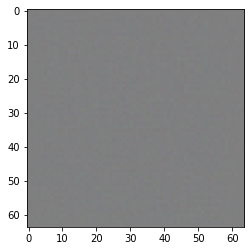

In [21]:
generator = make_generator_model((300,))

noise = np.random.normal(0, 1, 300)
label = train_captions[0]
print(label.shape)

generated_image = generator.predict( [np.array([noise]), np.array([label])] )[0][0]
plt.imshow(unnormalize_img(generated_image), )

In [22]:
def make_valid_discriminator_model():
    input_layer = Input((64, 64, 3))
#     x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', name='valid')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(64)(x) 
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    valid = Dense(1, activation='sigmoid')(x)
    
    return Model(input_layer, valid)

In [23]:
discriminator_valid = make_valid_discriminator_model()
discriminator_valid.summary()
valid = discriminator_valid.predict(np.array([generated_image]))


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
valid (Conv2D)               (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 32, 64)        0   

In [24]:
def make_attr_discriminator_model():
    input_layer = Input((64, 64, 3))
    
#     x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', name='attr')(input_layer)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)


#     x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
#     x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
#     x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
#     x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
#     x = Dense(128)(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    x = Dense(48)(x)
#     x = Dense(64)(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    attr = Dense(34, activation='sigmoid')(x)
    
    return Model(input_layer, attr)

In [25]:
discriminator_attr = make_attr_discriminator_model()
discriminator_attr.summary()
attrs = discriminator_attr.predict(np.array([generated_image]))

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
attr (Conv2D)                (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 16, 16, 128)       0   

In [26]:
cross_entropy = BinaryCrossentropy(from_logits=False)

@tf.function
def discriminator_valid_loss(real_output, fake_output, flip):
    
    if flip:
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.9, maxval=1.0)
        real_labels = tf.random.uniform(real_output.shape, minval=0.0, maxval=0.1)
    else:
        real_labels = tf.random.uniform(real_output.shape, minval=0.9, maxval=1.0)
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.0, maxval=0.1)

        
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

In [27]:
# mse = MeanSquaredError()

@tf.function
def discriminator_attribute_loss_real(real_output, real_attributes):
    return cross_entropy(real_output, real_attributes)

@tf.function
def discriminator_attribute_loss_fake(fake_output, fake_attributes):
    return cross_entropy(fake_output, fake_attributes)

In [28]:
@tf.function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def generator_attr_loss(fake_attr_output, sampled_attrs):
    return cross_entropy(fake_attr_output, sampled_attrs)

@tf.function
def generator_caption_loss(fake_caption_output, sampled_captions):
    return cross_entropy(fake_caption_output, sampled_captions)

In [68]:
@tf.function
def train_step(images, attrs, captions, sampled_attrs, sampled_captions, flip, warmup):
    noise = tf.random.truncated_normal([32, 300], dtype=tf.dtypes.float64)
    
#     sampled_attrs = tf.cast(tf.random.uniform([32, 312], minval=0, maxval=2, dtype='int32'), 'float32') # Need to make this smarter. Only one 1 per attr.
#     attrs = tf.reshape(attrs, (attrs.shape[0], 1))
    
    gen_losses = []
    gen_valid_losses = []
    gen_attr_losses = []
    gen_caption_losses = []
    disc_losses = []
    disc_real_losses = []
    disc_fake_losses = []
    disc_attr_real_losses = []
    disc_attr_fake_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape_valid, tf.GradientTape() as disc_tape_attr:
        gen_tape.watch(generator.trainable_variables)
        disc_tape_valid.watch(discriminator_valid.trainable_variables)
        disc_tape_attr.watch(discriminator_attr.trainable_variables)
        
        generated_images, generated_attrs = generator([noise, sampled_captions], training=True)
        
        real_output = discriminator_valid(images, training=True)
        fake_output = discriminator_valid(generated_images, training=True)
        
        real_attr_output = discriminator_attr(images, training=True)
        fake_attr_output = discriminator_attr(generated_images, training=True)
        
        gen_valid_loss = generator_loss(fake_output)
        gen_attr_loss = generator_attr_loss(fake_attr_output, sampled_attrs)
        gen_caption_loss = generator_caption_loss(generated_attrs, sampled_attrs)
        gen_loss = ((2.0 - warmup) * gen_valid_loss + (warmup * (gen_attr_loss + gen_caption_loss)))
        
        disc_valid_loss, disc_real_loss, disc_fake_loss = discriminator_valid_loss(real_output, fake_output, flip)
        disc_attr_real_loss = discriminator_attribute_loss_real(real_attr_output, attrs)
        disc_attr_fake_loss = discriminator_attribute_loss_fake(fake_attr_output, sampled_attrs)
        disc_attr_loss = ((2.0 - warmup) * disc_attr_real_loss + warmup * disc_attr_fake_loss)
#         disc_loss += ((2.0 - warmup) * disc_attr_real_loss + warmup * disc_attr_fake_loss)
        
        
        gen_losses.append(K.mean(gen_loss))
        gen_valid_losses.append(K.mean(gen_valid_loss))
        gen_attr_losses.append(K.mean(gen_attr_loss))
        gen_caption_losses.append(K.mean(gen_caption_loss))
        disc_losses.append(K.mean(disc_valid_loss))
        disc_real_losses.append(K.mean(disc_real_loss))
        disc_fake_losses.append(K.mean(disc_fake_loss))
        disc_attr_real_losses.append(K.mean(disc_attr_real_loss))
        disc_attr_fake_losses.append(K.mean(disc_attr_fake_loss))
    
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator_valid = disc_tape_valid.gradient(disc_valid_loss, discriminator_valid.trainable_variables)
    
    gradients_of_discriminator_attr = disc_tape_attr.gradient(disc_attr_loss, discriminator_attr.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    discriminator_valid_optimizer.apply_gradients(zip(gradients_of_discriminator_valid, discriminator_valid.trainable_variables))
    
    discriminator_attr_optimizer.apply_gradients(zip(gradients_of_discriminator_attr, discriminator_attr.trainable_variables))

    return (gen_losses, gen_valid_losses, gen_attr_losses, gen_caption_losses, disc_losses, disc_real_losses, disc_fake_losses, disc_attr_real_losses, disc_attr_fake_losses)

In [30]:
def train(train_imgs, train_attrs, train_captions, epochs, warmup):
    gen_loss_all = []
    gen_valid_loss_all = []
    gen_attr_loss_all = []
    gen_caption_loss_all = []
    disc_loss_all = []
    disc_loss_real_all = []
    disc_loss_fake_all = []
    disc_attr_loss_real_all = []
    disc_attr_loss_fake_all = []
    warmup_step = 1./2000.
    
    num_samples = len(train_imgs)
    batch_counter = 0
    
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        gen_valid_loss_epoch = [1, 0]
        gen_attr_loss_epoch = [1, 0]
        gen_caption_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        disc_loss_real_epoch = [1, 0]
        disc_loss_fake_epoch = [1, 0]
        disc_attr_loss_real_epoch = [1, 0]
        disc_attr_loss_fake_epoch = [1, 0]
        
        seed = np.random.randint(0, 10000)
        np.random.seed(seed)
        np.random.shuffle(train_imgs)
        np.random.seed(seed)
        np.random.shuffle(train_attrs)
        np.random.seed(seed)
        np.random.shuffle(train_captions)
        
        all_indices = np.arange(len(train_attrs))
        np.random.shuffle(all_indices)
        
        for idx, i in enumerate(range(0, num_samples - 32, 32)):
            
            sampled_indices = all_indices[i:(i+32)]
            
            gen_loss_batch, gen_valid_loss_batch, gen_attr_loss_batch, gen_caption_loss_batch, disc_loss_batch, disc_loss_real_batch, disc_loss_fake_batch, disc_attr_loss_real_batch, disc_attr_loss_fake_batch = train_step(train_imgs[i:(i+32)], train_attrs[i:(i+32)], train_captions[i:(i+32)], train_attrs[sampled_indices], train_captions[sampled_indices], batch_counter % 20 == 0, tf.constant(warmup, dtype='float32'))

            gen_loss_epoch[0] += 1
            gen_valid_loss_epoch[0] += 1
            gen_attr_loss_epoch[0] += 1
            gen_caption_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            disc_loss_real_epoch[0] += 1
            disc_loss_fake_epoch[0] += 1
            disc_attr_loss_real_epoch[0] += 1
            disc_attr_loss_fake_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            gen_valid_loss_epoch[1] += np.mean(gen_valid_loss_batch)
            gen_attr_loss_epoch[1] += np.mean(gen_attr_loss_batch)
            gen_caption_loss_epoch[1] += np.mean(gen_caption_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            disc_loss_real_epoch[1] += np.mean(disc_loss_real_batch)
            disc_loss_fake_epoch[1] += np.mean(disc_loss_fake_batch)
            disc_attr_loss_real_epoch[1] += np.mean(disc_attr_loss_real_batch)
            disc_attr_loss_fake_epoch[1] += np.mean(disc_attr_loss_fake_batch)
            
            batch_counter += 1
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Gen valid loss: {gen_valid_loss_epoch[1]/gen_valid_loss_epoch[0]}, Gen attr loss: {gen_attr_loss_epoch[1]/gen_attr_loss_epoch[0]}, Gen caption loss: {gen_caption_loss_epoch[1]/gen_caption_loss_epoch[0]}, Disc valid loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}, Disc valid real loss: {disc_loss_real_epoch[1]/disc_loss_real_epoch[0]}, Disc valid fake loss: {disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0]}, Disc attr loss: {(disc_attr_loss_real_epoch[1] + disc_attr_loss_fake_epoch[1])/(disc_attr_loss_real_epoch[0])}, Disc attr real loss: {disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0]}, Disc attr fake loss: {disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        gen_valid_loss_all.append(gen_valid_loss_epoch[1]/gen_valid_loss_epoch[0])
        gen_attr_loss_all.append(gen_attr_loss_epoch[1]/gen_attr_loss_epoch[0])
        gen_caption_loss_all.append(gen_caption_loss_epoch[1]/gen_caption_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
        disc_loss_real_all.append(disc_loss_real_epoch[1]/disc_loss_real_epoch[0])
        disc_loss_fake_all.append(disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0])
        disc_attr_loss_real_all.append(disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0])
        disc_attr_loss_fake_all.append(disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0])
        
        if warmup < 1:
            warmup += warmup_step
    
    return (gen_loss_all, gen_valid_loss_all, gen_attr_loss_all, gen_caption_loss_all, disc_loss_all, disc_loss_real_all, disc_loss_fake_all, disc_attr_loss_real_all, disc_attr_loss_fake_all, warmup)
    


In [42]:
def long_train(starting_checkpoint=0, num_checkpoints=0, checkpoint_interval=0, g_hist=None, g_valid_hist=None, g_attr_hist=None, g_caption_hist=None, d_hist=None, d_real_hist=None, d_fake_hist=None, d_attr_real_hist=None, d_attr_fake_hist=None, noise=None, caption=None, save_files=False, warmup=0.):

    for i in range(starting_checkpoint, starting_checkpoint + num_checkpoints):
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('')
        print(f'Starting checkpoint {i}')
        print('')
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        gen_temp, gen_valid_temp, gen_attr_temp, gen_caption_temp, disc_temp, disc_real_temp, disc_fake_temp, disc_attr_real_temp, disc_attr_fake_temp, warmup = train(train_imgs, train_attrs, train_captions, checkpoint_interval, warmup)
        
        g_hist += gen_temp
        g_valid_hist += gen_valid_temp
        g_attr_hist += gen_attr_temp
        g_caption_hist += gen_caption_temp
        d_hist += disc_temp
        d_real_hist += disc_real_temp
        d_fake_hist += disc_fake_temp
        d_attr_real_hist += disc_attr_real_temp
        d_attr_fake_hist += disc_attr_fake_temp
        generated_image = generator.predict( [np.array([noise]), np.array([caption])])[0][0]
        plt.imshow(unnormalize_img(generated_image))
        if save_files:
            plt.savefig('./results/prog-imgs/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/' + str((i+1)*checkpoint_interval) + '.png')
        plt.show()
        if save_files:
            generator.save_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/gen_weights_attributes_split_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator_valid.save_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/disc_weights_attributes_split_valid_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator_attr.save_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/disc_weights_attributes_split_attr_' + str((i+1)*checkpoint_interval) + '.h5')
            save_plots((i+1)*checkpoint_interval)
    
    return starting_checkpoint + num_checkpoints, totalepochs, warmup

In [66]:
discriminator_valid = make_valid_discriminator_model()
discriminator_attr = make_attr_discriminator_model()
generator = make_generator_model((300,))
generator_optimizer = Adam(1e-4, beta_1=0.5)
discriminator_valid_optimizer = Adam(1e-4, beta_1=0.5)
discriminator_attr_optimizer = Adam(1e-5, beta_1=0.5)

In [67]:
# To get passed into training function and get modified
# Run cell when starting from scratch
gen_loss_hist = []
gen_valid_loss_hist = []
gen_attr_loss_hist = []
gen_caption_loss_hist = []
disc_loss_hist = []
disc_loss_real_hist = []
disc_loss_fake_hist = []
disc_attr_loss_real_hist = []
disc_attr_loss_fake_hist = []
noise300 = np.random.normal(0, 1, 300)
caption = train_captions[5000]
next_starting_checkpoint = 0
totalepochs = 0
warmup = 1.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 40.82563233375549 sec
Gen loss: 6.583544203905555, Gen valid loss: 1.6269683447340881, Gen attr loss: 3.3757763025237293, Gen caption loss: 1.5807995679901867, Disc valid loss: 1.0463322970440718, Disc valid real loss: 0.5428157501265931, Disc valid fake loss: 0.5035165471193913, Disc attr loss: 7.2131214057849995, Disc attr real loss: 3.8373451032612707, Disc attr fake loss: 3.3757763025237293
Time for epoch 2 is 36.812443256378174 sec
Gen loss: 4.959641390699681, Gen valid loss: 0.8244709577663805, Gen attr loss: 2.5562112066480847, Gen caption loss: 1.5789592169164641, Disc valid loss: 1.2671753021113594, Disc valid real loss: 0.6324202016117128, Disc valid fake loss: 0.6347551003381166, Disc attr loss: 5.112021134797796, Disc attr real loss: 2.5558099281497118, Disc attr fake loss: 2.5562112066480847
Time for epoch 3 is 37.49520492553711 sec
Gen lo

Time for epoch 21 is 38.84548211097717 sec
Gen loss: 5.17070061727591, Gen valid loss: 1.0799641034144374, Gen attr loss: 2.520932558106213, Gen caption loss: 1.5698039725544006, Disc valid loss: 1.1558983639326845, Disc valid real loss: 0.6165050866642618, Disc valid fake loss: 0.5393932767838321, Disc attr loss: 5.042188240583673, Disc attr real loss: 2.52125568247746, Disc attr fake loss: 2.520932558106213
Time for epoch 22 is 38.760364055633545 sec
Gen loss: 5.213227277202658, Gen valid loss: 1.1290696190624703, Gen attr loss: 2.5146408597951337, Gen caption loss: 1.5695168073907455, Disc valid loss: 1.137244923651057, Disc valid real loss: 0.6073975009000722, Disc valid fake loss: 0.5298474235586358, Disc attr loss: 5.037432585951436, Disc attr real loss: 2.522791726156302, Disc attr fake loss: 2.5146408597951337
Time for epoch 23 is 38.819135904312134 sec
Gen loss: 5.233589478624546, Gen valid loss: 1.1468866399633206, Gen attr loss: 2.5190593795724676, Gen caption loss: 1.567643

Time for epoch 41 is 38.80907964706421 sec
Gen loss: 5.347434135633432, Gen valid loss: 1.2655007488682342, Gen attr loss: 2.518098475810312, Gen caption loss: 1.5638349059474501, Disc valid loss: 1.067648036047049, Disc valid real loss: 0.5733114426052021, Disc valid fake loss: 0.49433659174577976, Disc attr loss: 5.031516991979707, Disc attr real loss: 2.5134185161693954, Disc attr fake loss: 2.518098475810312
Time for epoch 42 is 38.77860116958618 sec
Gen loss: 5.3998275785265255, Gen valid loss: 1.315145114734567, Gen attr loss: 2.518888023810658, Gen caption loss: 1.5657944310971392, Disc valid loss: 1.0659966160288348, Disc valid real loss: 0.568670397689995, Disc valid fake loss: 0.49732621736965854, Disc attr loss: 5.032150363534447, Disc attr real loss: 2.5132623397237888, Disc attr fake loss: 2.518888023810658
Time for epoch 43 is 38.861098289489746 sec
Gen loss: 5.357872252218769, Gen valid loss: 1.2761772609338529, Gen attr loss: 2.5167392954270693, Gen caption loss: 1.5649

Time for epoch 61 is 38.860636949539185 sec
Gen loss: 4.457431931482744, Gen valid loss: 1.235946094440574, Gen attr loss: 1.6568129993066556, Gen caption loss: 1.5646728345049106, Disc valid loss: 1.0833121769150422, Disc valid real loss: 0.5745606209204449, Disc valid fake loss: 0.5087515535716441, Disc attr loss: 3.3108040052377756, Disc attr real loss: 1.6539910059311203, Disc attr fake loss: 1.6568129993066556
Time for epoch 62 is 38.5158908367157 sec
Gen loss: 4.461107743141774, Gen valid loss: 1.2424713474948232, Gen attr loss: 1.6579818942036408, Gen caption loss: 1.5606545142041959, Disc valid loss: 1.071306031570848, Disc valid real loss: 0.5715038791743074, Disc valid fake loss: 0.49980215271960104, Disc attr loss: 3.3112753610300825, Disc attr real loss: 1.6532934668264414, Disc attr fake loss: 1.6579818942036408
Time for epoch 63 is 38.792405128479004 sec
Gen loss: 4.463843615720589, Gen valid loss: 1.2433036044038086, Gen attr loss: 1.659969955278929, Gen caption loss: 1.

Time for epoch 81 is 38.76566290855408 sec
Gen loss: 4.4506120623611825, Gen valid loss: 1.2334793481400343, Gen attr loss: 1.6584590528069474, Gen caption loss: 1.5586736534992207, Disc valid loss: 1.0802764105926037, Disc valid real loss: 0.5766083384109383, Disc valid fake loss: 0.5036680720201353, Disc attr loss: 3.3089950482050576, Disc attr real loss: 1.6505359953981105, Disc attr fake loss: 1.6584590528069474
Time for epoch 82 is 38.63382530212402 sec
Gen loss: 4.429937648256296, Gen valid loss: 1.213390485219516, Gen attr loss: 1.6578605478695092, Gen caption loss: 1.5586866066061706, Disc valid loss: 1.0906648650401976, Disc valid real loss: 0.5775668489416117, Disc valid fake loss: 0.5130980165024114, Disc attr loss: 3.3078991239309956, Disc attr real loss: 1.6500385760614866, Disc attr fake loss: 1.6578605478695092
Time for epoch 83 is 38.859678745269775 sec
Gen loss: 4.4435320688780084, Gen valid loss: 1.2219814367410613, Gen attr loss: 1.6604617866397227, Gen caption loss:

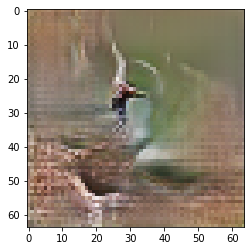

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 1

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.66821312904358 sec
Gen loss: 4.381134466750189, Gen valid loss: 1.2062526333945875, Gen attr loss: 1.614814978951038, Gen caption loss: 1.5600668466511134, Disc valid loss: 1.094042189883669, Disc valid real loss: 0.5786513165245212, Disc valid fake loss: 0.5153908750552149, Disc attr loss: 3.206541977923737, Disc attr real loss: 1.591726998972699, Disc attr fake loss: 1.614814978951038
Time for epoch 2 is 38.489195585250854 sec
Gen loss: 4.4006512817651595, Gen valid loss: 1.2313454755276523, Gen attr loss: 1.610722746629379, Gen caption loss: 1.5585830579928266, Disc valid loss: 1.0805986152108769, Disc valid real loss: 0.5763752083306714, Disc valid fake loss: 0.504223408010917, Disc attr loss: 3.201619194775093, Disc attr real loss: 1.590896448145714, Disc attr fake loss: 1.610722746629379
Time for epoch 3 is 38.845224142074585 sec
Gen loss: 4.3

Time for epoch 21 is 38.51369309425354 sec
Gen loss: 4.3853650009082905, Gen valid loss: 1.2181815211042801, Gen attr loss: 1.610714203943082, Gen caption loss: 1.5564692789300025, Disc valid loss: 1.101347057153862, Disc valid real loss: 0.583689937181266, Disc valid fake loss: 0.5176571185995893, Disc attr loss: 3.19683896881455, Disc attr real loss: 1.586124764871468, Disc attr fake loss: 1.610714203943082
Time for epoch 22 is 38.52590489387512 sec
Gen loss: 4.379692933100672, Gen valid loss: 1.2179459115354025, Gen attr loss: 1.6065445243504635, Gen caption loss: 1.5552025041606046, Disc valid loss: 1.091432658475912, Disc valid real loss: 0.5742646571258866, Disc valid fake loss: 0.5171680015115557, Disc attr loss: 3.193633759894022, Disc attr real loss: 1.5870892355435586, Disc attr fake loss: 1.6065445243504635
Time for epoch 23 is 38.59061789512634 sec
Gen loss: 4.389780588589386, Gen valid loss: 1.2196438971573744, Gen attr loss: 1.6125015970168075, Gen caption loss: 1.5576351

Time for epoch 41 is 38.50068712234497 sec
Gen loss: 4.385388924177423, Gen valid loss: 1.2162057448854937, Gen attr loss: 1.6119359557221575, Gen caption loss: 1.5572472235697719, Disc valid loss: 1.0957729033015284, Disc valid real loss: 0.5778852625267938, Disc valid fake loss: 0.5178876406132045, Disc attr loss: 3.192651385537331, Disc attr real loss: 1.5807154298151735, Disc attr fake loss: 1.6119359557221575
Time for epoch 42 is 38.5759551525116 sec
Gen loss: 4.40147770775689, Gen valid loss: 1.2380127344674212, Gen attr loss: 1.6077420889200558, Gen caption loss: 1.5557228814618698, Disc valid loss: 1.0749909197734946, Disc valid real loss: 0.5633796227333668, Disc valid fake loss: 0.5116112984938996, Disc attr loss: 3.1887250447337867, Disc attr real loss: 1.580982955813731, Disc attr fake loss: 1.6077420889200558
Time for epoch 43 is 38.54842734336853 sec
Gen loss: 4.371627025164886, Gen valid loss: 1.2105935017267864, Gen attr loss: 1.6079569353966856, Gen caption loss: 1.553

Time for epoch 61 is 38.504358768463135 sec
Gen loss: 4.3599932310057845, Gen valid loss: 1.2017602917301622, Gen attr loss: 1.604924896222143, Gen caption loss: 1.5533080446687817, Disc valid loss: 1.1023507804728458, Disc valid real loss: 0.5802557160699271, Disc valid fake loss: 0.5220950634337376, Disc attr loss: 3.1822631801693095, Disc attr real loss: 1.5773382839471668, Disc attr fake loss: 1.604924896222143
Time for epoch 62 is 38.52998375892639 sec
Gen loss: 4.384548420505472, Gen valid loss: 1.2230264140661493, Gen attr loss: 1.602975589473073, Gen caption loss: 1.5585464329577396, Disc valid loss: 1.088475107015956, Disc valid real loss: 0.5727936346033401, Disc valid fake loss: 0.515681472412616, Disc attr loss: 3.1793076788506855, Disc attr real loss: 1.5763320893776127, Disc attr fake loss: 1.602975589473073
Time for epoch 63 is 38.55662250518799 sec
Gen loss: 4.360453205703074, Gen valid loss: 1.1989363567615912, Gen attr loss: 1.6055229999185578, Gen caption loss: 1.555

Time for epoch 81 is 38.517582178115845 sec
Gen loss: 4.361161856147332, Gen valid loss: 1.1974609348832108, Gen attr loss: 1.6073405855716405, Gen caption loss: 1.556360341669098, Disc valid loss: 1.1054369766860797, Disc valid real loss: 0.5822415026384318, Disc valid fake loss: 0.5231954746937687, Disc attr loss: 3.180647093429152, Disc attr real loss: 1.5733065078575112, Disc attr fake loss: 1.6073405855716405
Time for epoch 82 is 38.595921993255615 sec
Gen loss: 4.3496346628762845, Gen valid loss: 1.1913075435775404, Gen attr loss: 1.6055952837150596, Gen caption loss: 1.5527318305762479, Disc valid loss: 1.1086600448704025, Disc valid real loss: 0.5824742999664814, Disc valid fake loss: 0.5261857460346325, Disc attr loss: 3.1779395962149146, Disc attr real loss: 1.5723443124998553, Disc attr fake loss: 1.6055952837150596
Time for epoch 83 is 38.5061309337616 sec
Gen loss: 4.3521580133980855, Gen valid loss: 1.1924223408789492, Gen attr loss: 1.6047234958426415, Gen caption loss: 

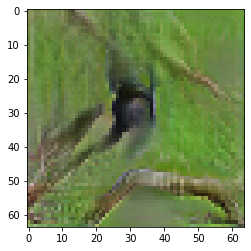

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 2

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.166175842285156 sec
Gen loss: 4.342751259403177, Gen valid loss: 1.1899232748078137, Gen attr loss: 1.6000475812410597, Gen caption loss: 1.5527804091693909, Disc valid loss: 1.1088064422775414, Disc valid real loss: 0.5783363470863198, Disc valid fake loss: 0.530470097129584, Disc attr loss: 3.1691209174753205, Disc attr real loss: 1.5690733362342606, Disc attr fake loss: 1.6000475812410597
Time for epoch 2 is 38.60709547996521 sec
Gen loss: 4.355067934770248, Gen valid loss: 1.194291790003376, Gen attr loss: 1.607329121773159, Gen caption loss: 1.5534470165325052, Disc valid loss: 1.0996277619829669, Disc valid real loss: 0.5803063200095159, Disc valid fake loss: 0.5193214412465651, Disc attr loss: 3.175275438523228, Disc attr real loss: 1.567946316750069, Disc attr fake loss: 1.607329121773159
Time for epoch 3 is 38.23495101928711 sec
Gen loss: 4

Time for epoch 21 is 38.37898921966553 sec
Gen loss: 4.357367739121766, Gen valid loss: 1.1956230792895888, Gen attr loss: 1.605190894468044, Gen caption loss: 1.5565537702100387, Disc valid loss: 1.107840754475374, Disc valid real loss: 0.5817041568316741, Disc valid fake loss: 0.5261365990974716, Disc attr loss: 3.170008054593714, Disc attr real loss: 1.5648171601256704, Disc attr fake loss: 1.605190894468044
Time for epoch 22 is 38.388118505477905 sec
Gen loss: 4.361194597027166, Gen valid loss: 1.2046017871316532, Gen attr loss: 1.6042559027348753, Gen caption loss: 1.5523369111988925, Disc valid loss: 1.1066198235927882, Disc valid real loss: 0.573947996870289, Disc valid fake loss: 0.5326718232495998, Disc attr loss: 3.169270905698864, Disc attr real loss: 1.5650150029639887, Disc attr fake loss: 1.6042559027348753
Time for epoch 23 is 38.44811010360718 sec
Gen loss: 4.358713529943451, Gen valid loss: 1.1999614854169085, Gen attr loss: 1.6046349957060362, Gen caption loss: 1.5541

Time for epoch 41 is 38.36712956428528 sec
Gen loss: 4.338921301410127, Gen valid loss: 1.18151633865465, Gen attr loss: 1.605207610905655, Gen caption loss: 1.5521973639645874, Disc valid loss: 1.1175357235802545, Disc valid real loss: 0.5876596809079654, Disc valid fake loss: 0.5298760385532689, Disc attr loss: 3.166575827572727, Disc attr real loss: 1.561368216667072, Disc attr fake loss: 1.605207610905655
Time for epoch 42 is 38.41335678100586 sec
Gen loss: 4.351722216541528, Gen valid loss: 1.194625956902336, Gen attr loss: 1.6046545295534418, Gen caption loss: 1.5524417342855354, Disc valid loss: 1.106703398673515, Disc valid real loss: 0.5791239166647438, Disc valid fake loss: 0.5275794786166369, Disc attr loss: 3.1656814920223826, Disc attr real loss: 1.5610269624689408, Disc attr fake loss: 1.6046545295534418
Time for epoch 43 is 38.35730504989624 sec
Gen loss: 4.353533057339469, Gen valid loss: 1.200019297399495, Gen attr loss: 1.60303563380306, Gen caption loss: 1.5504781149

Time for epoch 61 is 38.392457008361816 sec
Gen loss: 4.356910186085274, Gen valid loss: 1.1934061014878394, Gen attr loss: 1.6065014229234318, Gen caption loss: 1.5570026539205535, Disc valid loss: 1.116827566449235, Disc valid real loss: 0.5826919860633085, Disc valid fake loss: 0.5341355814358729, Disc attr loss: 3.165325900726525, Disc attr real loss: 1.5588244778030933, Disc attr fake loss: 1.6065014229234318
Time for epoch 62 is 38.323986530303955 sec
Gen loss: 4.358615964408813, Gen valid loss: 1.1982963910593896, Gen attr loss: 1.6064476718101397, Gen caption loss: 1.5538718836094305, Disc valid loss: 1.1038336992909914, Disc valid real loss: 0.5757322951868621, Disc valid fake loss: 0.5281014055579012, Disc attr loss: 3.1647521906751925, Disc attr real loss: 1.5583045188650528, Disc attr fake loss: 1.6064476718101397
Time for epoch 63 is 38.46274375915527 sec
Gen loss: 4.357037539727642, Gen valid loss: 1.1996698478050025, Gen attr loss: 1.6045779080248783, Gen caption loss: 1

Time for epoch 81 is 38.36930799484253 sec
Gen loss: 4.366339662210728, Gen valid loss: 1.2059211939330992, Gen attr loss: 1.6050935935198776, Gen caption loss: 1.5553248959182078, Disc valid loss: 1.1080186846779614, Disc valid real loss: 0.5777414488760113, Disc valid fake loss: 0.5302772366903662, Disc attr loss: 3.1599058533102515, Disc attr real loss: 1.554812259790374, Disc attr fake loss: 1.6050935935198776
Time for epoch 82 is 38.405841588974 sec
Gen loss: 4.367783715731406, Gen valid loss: 1.212273226036289, Gen attr loss: 1.6033952914602387, Gen caption loss: 1.5521152206875768, Disc valid loss: 1.0977531333925925, Disc valid real loss: 0.5718674363321082, Disc valid fake loss: 0.5258856992411419, Disc attr loss: 3.158182156764395, Disc attr real loss: 1.554786865304156, Disc attr fake loss: 1.6033952914602387
Time for epoch 83 is 38.38331913948059 sec
Gen loss: 4.3686561539244195, Gen valid loss: 1.2202276014054048, Gen attr loss: 1.6008502965374045, Gen caption loss: 1.5475

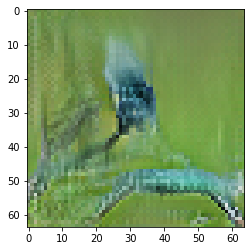

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 3

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.41741752624512 sec
Gen loss: 4.356471549527755, Gen valid loss: 1.206548208305183, Gen attr loss: 1.6007715822235355, Gen caption loss: 1.5491517585144456, Disc valid loss: 1.1105959357284918, Disc valid real loss: 0.5780174873547179, Disc valid fake loss: 0.5325784482122436, Disc attr loss: 3.1523657433062713, Disc attr real loss: 1.5515941610827355, Disc attr fake loss: 1.6007715822235355
Time for epoch 2 is 38.45460748672485 sec
Gen loss: 4.364624316130227, Gen valid loss: 1.2126258572911828, Gen attr loss: 1.6017143277294914, Gen caption loss: 1.5502841336940363, Disc valid loss: 1.0995933780179115, Disc valid real loss: 0.5753147420359821, Disc valid fake loss: 0.5242786370318756, Disc attr loss: 3.1527491513952652, Disc attr real loss: 1.551034823665774, Disc attr fake loss: 1.6017143277294914
Time for epoch 3 is 38.358187437057495 sec
Gen los

Time for epoch 21 is 38.33433651924133 sec
Gen loss: 4.384586601722531, Gen valid loss: 1.2246637903254853, Gen attr loss: 1.6049455413973428, Gen caption loss: 1.5549772674152198, Disc valid loss: 1.10177526612915, Disc valid real loss: 0.5761028140541015, Disc valid fake loss: 0.525672450055921, Disc attr loss: 3.153649288464368, Disc attr real loss: 1.548703747067025, Disc attr fake loss: 1.6049455413973428
Time for epoch 22 is 38.37350583076477 sec
Gen loss: 4.361559665623073, Gen valid loss: 1.2146039430688067, Gen attr loss: 1.6002854774314859, Gen caption loss: 1.5466702527146998, Disc valid loss: 1.1013880554576554, Disc valid real loss: 0.5733939498905244, Disc valid fake loss: 0.5279941051633055, Disc attr loss: 3.1490408812111954, Disc attr real loss: 1.5487554037797095, Disc attr fake loss: 1.6002854774314859
Time for epoch 23 is 38.40968656539917 sec
Gen loss: 4.371143229285553, Gen valid loss: 1.2147343775767299, Gen attr loss: 1.6036057866362698, Gen caption loss: 1.5528

Time for epoch 41 is 38.32107090950012 sec
Gen loss: 4.3566530513246535, Gen valid loss: 1.2121238193214747, Gen attr loss: 1.598331796767589, Gen caption loss: 1.5461974567191064, Disc valid loss: 1.1048722149233832, Disc valid real loss: 0.575650196976778, Disc valid fake loss: 0.5292220154832695, Disc attr loss: 3.1443947059352224, Disc attr real loss: 1.5460629091676334, Disc attr fake loss: 1.598331796767589
Time for epoch 42 is 38.344523906707764 sec
Gen loss: 4.364142803641839, Gen valid loss: 1.2132613624983686, Gen attr loss: 1.6009032913662877, Gen caption loss: 1.5499781405699609, Disc valid loss: 1.1021229232229837, Disc valid real loss: 0.5758925262828506, Disc valid fake loss: 0.5262303950825358, Disc attr loss: 3.14688398489138, Disc attr real loss: 1.5459806935250922, Disc attr fake loss: 1.6009032913662877
Time for epoch 43 is 38.35302972793579 sec
Gen loss: 4.363616593161896, Gen valid loss: 1.2143250886340775, Gen attr loss: 1.6007362084013983, Gen caption loss: 1.54

Time for epoch 61 is 38.27073860168457 sec
Gen loss: 4.36526900965993, Gen valid loss: 1.2100002575049877, Gen attr loss: 1.6048634750087087, Gen caption loss: 1.5504052748848107, Disc valid loss: 1.1126088545251345, Disc valid real loss: 0.577458914137145, Disc valid fake loss: 0.5351499385303922, Disc attr loss: 3.148568279374906, Disc attr real loss: 1.543704804366197, Disc attr fake loss: 1.6048634750087087
Time for epoch 62 is 38.31846642494202 sec
Gen loss: 4.346710406021697, Gen valid loss: 1.2032437427903255, Gen attr loss: 1.595975359280904, Gen caption loss: 1.5474913058888298, Disc valid loss: 1.1045278055558037, Disc valid real loss: 0.5779452598514919, Disc valid fake loss: 0.5265825472388487, Disc attr loss: 3.1386958845262605, Disc attr real loss: 1.5427205252453564, Disc attr fake loss: 1.595975359280904
Time for epoch 63 is 38.27403163909912 sec
Gen loss: 4.3634147308060145, Gen valid loss: 1.2056346530836772, Gen attr loss: 1.6027409051491963, Gen caption loss: 1.5550

Time for epoch 81 is 38.35310506820679 sec
Gen loss: 4.369845596432363, Gen valid loss: 1.2240814472924726, Gen attr loss: 1.5994349217350243, Gen caption loss: 1.5463292178745838, Disc valid loss: 1.0988896999578812, Disc valid real loss: 0.5690920880331902, Disc valid fake loss: 0.5297976143476439, Disc attr loss: 3.141821410274764, Disc attr real loss: 1.5423864885397396, Disc attr fake loss: 1.5994349217350243
Time for epoch 82 is 38.382975816726685 sec
Gen loss: 4.3782579162256505, Gen valid loss: 1.2242879907936262, Gen attr loss: 1.602400998112955, Gen caption loss: 1.5515689219885724, Disc valid loss: 1.0930038081598152, Disc valid real loss: 0.5708682002413886, Disc valid fake loss: 0.5221356078376614, Disc attr loss: 3.1439393060963328, Disc attr real loss: 1.5415383079833778, Disc attr fake loss: 1.602400998112955
Time for epoch 83 is 38.35335063934326 sec
Gen loss: 4.381208847531782, Gen valid loss: 1.2279897080204352, Gen attr loss: 1.6014334822734844, Gen caption loss: 1.

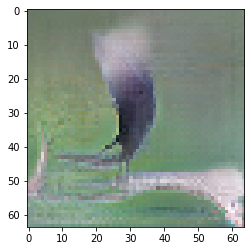

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 4

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.37337398529053 sec
Gen loss: 4.380368772884048, Gen valid loss: 1.224377752965705, Gen attr loss: 1.60377078973827, Gen caption loss: 1.5522202447177917, Disc valid loss: 1.0992065356352787, Disc valid real loss: 0.5720459636310898, Disc valid fake loss: 0.5271605702273567, Disc attr loss: 3.1441041925735265, Disc attr real loss: 1.5403334028352567, Disc attr fake loss: 1.60377078973827
Time for epoch 2 is 38.82776141166687 sec
Gen loss: 4.379106836913401, Gen valid loss: 1.225472218460507, Gen attr loss: 1.6040052698879708, Gen caption loss: 1.5496293648794737, Disc valid loss: 1.0913405799607274, Disc valid real loss: 0.5669900669961118, Disc valid fake loss: 0.5243505149029781, Disc attr loss: 3.143710742797955, Disc attr real loss: 1.5397054729099842, Disc attr fake loss: 1.6040052698879708
Time for epoch 3 is 38.638615131378174 sec
Gen loss: 4.

Time for epoch 21 is 38.55801033973694 sec
Gen loss: 4.373216534048561, Gen valid loss: 1.2211596880178788, Gen attr loss: 1.6009458019158382, Gen caption loss: 1.551111036845985, Disc valid loss: 1.106412643501106, Disc valid real loss: 0.5736687740659326, Disc valid fake loss: 0.5327438662853344, Disc attr loss: 3.1392510069741144, Disc attr real loss: 1.5383052050582762, Disc attr fake loss: 1.6009458019158382
Time for epoch 22 is 38.59702515602112 sec
Gen loss: 4.401182614044768, Gen valid loss: 1.2419473084653943, Gen attr loss: 1.60697797708072, Gen caption loss: 1.5522573330215, Disc valid loss: 1.0885833653654187, Disc valid real loss: 0.5615186336725385, Disc valid fake loss: 0.5270647296737526, Disc attr loss: 3.145238154625828, Disc attr real loss: 1.5382601775451081, Disc attr fake loss: 1.60697797708072
Time for epoch 23 is 38.60183644294739 sec
Gen loss: 4.391518282050363, Gen valid loss: 1.2378225019630702, Gen attr loss: 1.6023756979603754, Gen caption loss: 1.551320075

Time for epoch 41 is 38.641910552978516 sec
Gen loss: 4.3745295167938485, Gen valid loss: 1.2264121707861986, Gen attr loss: 1.5996295569065786, Gen caption loss: 1.548487789908722, Disc valid loss: 1.1054189802831427, Disc valid real loss: 0.5752287926228066, Disc valid fake loss: 0.5301901878218663, Disc attr loss: 3.1361796439178593, Disc attr real loss: 1.5365500870112805, Disc attr fake loss: 1.5996295569065786
Time for epoch 42 is 38.56416440010071 sec
Gen loss: 4.360431347436052, Gen valid loss: 1.2110605982907097, Gen attr loss: 1.603141047444124, Gen caption loss: 1.5462296865173795, Disc valid loss: 1.097413841463363, Disc valid real loss: 0.5693899618416298, Disc valid fake loss: 0.5280238821254513, Disc attr loss: 3.1397692724295103, Disc attr real loss: 1.5366282249853862, Disc attr fake loss: 1.603141047444124
Time for epoch 43 is 38.58812093734741 sec
Gen loss: 4.388247734808987, Gen valid loss: 1.2241448551658693, Gen attr loss: 1.6086059278912015, Gen caption loss: 1.5

Time for epoch 61 is 38.54626393318176 sec
Gen loss: 4.367401536564194, Gen valid loss: 1.2206126115509488, Gen attr loss: 1.6000799793538039, Gen caption loss: 1.546708955997374, Disc valid loss: 1.1045652972004278, Disc valid real loss: 0.5701371498385742, Disc valid fake loss: 0.5344281446158401, Disc attr loss: 3.1351494646976956, Disc attr real loss: 1.5350694853438918, Disc attr fake loss: 1.6000799793538039
Time for epoch 62 is 38.567211627960205 sec
Gen loss: 4.386477587345816, Gen valid loss: 1.2335168934126857, Gen attr loss: 1.6020591578832486, Gen caption loss: 1.5509015383113045, Disc valid loss: 1.0872315591589867, Disc valid real loss: 0.5652547541672621, Disc valid fake loss: 0.5219768066070267, Disc attr loss: 3.137453255614614, Disc attr real loss: 1.5353940977313654, Disc attr fake loss: 1.6020591578832486
Time for epoch 63 is 38.63460922241211 sec
Gen loss: 4.37723886675951, Gen valid loss: 1.2258950662483692, Gen attr loss: 1.60157926328137, Gen caption loss: 1.549

Time for epoch 81 is 38.59780025482178 sec
Gen loss: 4.374937843178023, Gen valid loss: 1.2161420628953432, Gen attr loss: 1.605273822458779, Gen caption loss: 1.5535219568547194, Disc valid loss: 1.101714021306697, Disc valid real loss: 0.5711810152705122, Disc valid fake loss: 0.5305330071668961, Disc attr loss: 3.1390101689956373, Disc attr real loss: 1.5337363465368585, Disc attr fake loss: 1.605273822458779
Time for epoch 82 is 38.621655225753784 sec
Gen loss: 4.382298209156771, Gen valid loss: 1.2271223557673818, Gen attr loss: 1.6019359659050216, Gen caption loss: 1.5532398902303803, Disc valid loss: 1.0934151638814105, Disc valid real loss: 0.5684325850914488, Disc valid fake loss: 0.524982580647559, Disc attr loss: 3.136626223238503, Disc attr real loss: 1.5346902573334815, Disc attr fake loss: 1.6019359659050216
Time for epoch 83 is 38.593101024627686 sec
Gen loss: 4.3793736615478185, Gen valid loss: 1.2286746178862202, Gen attr loss: 1.6031529312211323, Gen caption loss: 1.5

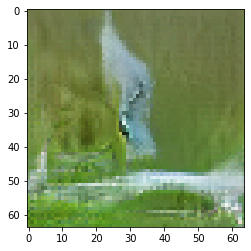

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 5

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.556517124176025 sec
Gen loss: 4.376531009105486, Gen valid loss: 1.2277180400644214, Gen attr loss: 1.5985416923435076, Gen caption loss: 1.5502712901045637, Disc valid loss: 1.0954461903752997, Disc valid real loss: 0.5666351076064071, Disc valid fake loss: 0.5288110830919529, Disc attr loss: 3.131601802055752, Disc attr real loss: 1.533060109712244, Disc attr fake loss: 1.5985416923435076
Time for epoch 2 is 38.68854570388794 sec
Gen loss: 4.395729804749735, Gen valid loss: 1.2434837068645612, Gen attr loss: 1.603625412555891, Gen caption loss: 1.5486206682070807, Disc valid loss: 1.100340168489027, Disc valid real loss: 0.5640659385580358, Disc valid fake loss: 0.5362742309405552, Disc attr loss: 3.13616226746784, Disc attr real loss: 1.532536854911949, Disc attr fake loss: 1.603625412555891
Time for epoch 3 is 38.372706174850464 sec
Gen loss: 4.

Time for epoch 21 is 39.103121280670166 sec
Gen loss: 4.392544931835598, Gen valid loss: 1.2412097580064603, Gen attr loss: 1.6022924446478122, Gen caption loss: 1.5490427411345609, Disc valid loss: 1.098017578525595, Disc valid real loss: 0.566136592125828, Disc valid fake loss: 0.5318809868843575, Disc attr loss: 3.1342903747145074, Disc attr real loss: 1.5319979300666955, Disc attr fake loss: 1.6022924446478122
Time for epoch 22 is 38.62325310707092 sec
Gen loss: 4.393353946809846, Gen valid loss: 1.2421077481776395, Gen attr loss: 1.6035445024004473, Gen caption loss: 1.5477016951010478, Disc valid loss: 1.0893164146237257, Disc valid real loss: 0.5622517835641618, Disc valid fake loss: 0.527064629605792, Disc attr loss: 3.1351039729467254, Disc attr real loss: 1.5315594705462778, Disc attr fake loss: 1.6035445024004473
Time for epoch 23 is 38.6174795627594 sec
Gen loss: 4.384281339361093, Gen valid loss: 1.233793603695505, Gen attr loss: 1.6018428314669022, Gen caption loss: 1.548

Time for epoch 41 is 38.67712593078613 sec
Gen loss: 4.383015568663434, Gen valid loss: 1.2358908473960752, Gen attr loss: 1.5984757657296613, Gen caption loss: 1.5486489611912548, Disc valid loss: 1.0960443118400367, Disc valid real loss: 0.5701257613939321, Disc valid fake loss: 0.5259185504461046, Disc attr loss: 3.129327251982237, Disc attr real loss: 1.5308514862525753, Disc attr fake loss: 1.5984757657296613
Time for epoch 42 is 38.608439445495605 sec
Gen loss: 4.386995381456081, Gen valid loss: 1.242953526618358, Gen attr loss: 1.5965743216718762, Gen caption loss: 1.547467532196665, Disc valid loss: 1.0913706027718417, Disc valid real loss: 0.5646863414181603, Disc valid fake loss: 0.5266842598999096, Disc attr loss: 3.127928476669601, Disc attr real loss: 1.5313541549977248, Disc attr fake loss: 1.5965743216718762
Time for epoch 43 is 38.65286374092102 sec
Gen loss: 4.398498300614396, Gen valid loss: 1.2335786449553843, Gen attr loss: 1.6087887222527812, Gen caption loss: 1.55

Time for epoch 61 is 38.62216806411743 sec
Gen loss: 4.376647931773488, Gen valid loss: 1.23111847115726, Gen attr loss: 1.5959740831923033, Gen caption loss: 1.5495553905078712, Disc valid loss: 1.1043003224098908, Disc valid real loss: 0.5750483125044401, Disc valid fake loss: 0.5292520094208601, Disc attr loss: 3.1263559365337135, Disc attr real loss: 1.5303818533414102, Disc attr fake loss: 1.5959740831923033
Time for epoch 62 is 38.67598748207092 sec
Gen loss: 4.385003459485889, Gen valid loss: 1.2350276052790283, Gen attr loss: 1.6006161116649142, Gen caption loss: 1.549359742218886, Disc valid loss: 1.093790833058396, Disc valid real loss: 0.5679986165144902, Disc valid fake loss: 0.5257922178361474, Disc attr loss: 3.130078818416854, Disc attr real loss: 1.5294627067519397, Disc attr fake loss: 1.6006161116649142
Time for epoch 63 is 38.67017722129822 sec
Gen loss: 4.391012881183366, Gen valid loss: 1.2423230028410914, Gen attr loss: 1.6001469087471485, Gen caption loss: 1.5485

Time for epoch 81 is 38.70125222206116 sec
Gen loss: 4.371619161228501, Gen valid loss: 1.229601434575833, Gen attr loss: 1.5958533403350086, Gen caption loss: 1.5461643859945984, Disc valid loss: 1.1042514149412552, Disc valid real loss: 0.5723080474348249, Disc valid fake loss: 0.5319433682333163, Disc attr loss: 3.124721350708628, Disc attr real loss: 1.5288680103736194, Disc attr fake loss: 1.5958533403350086
Time for epoch 82 is 38.6432421207428 sec
Gen loss: 4.385272328446551, Gen valid loss: 1.2377218634778568, Gen attr loss: 1.59838078855499, Gen caption loss: 1.549169692243664, Disc valid loss: 1.0954963868549523, Disc valid real loss: 0.5670245152501879, Disc valid fake loss: 0.5284718707163483, Disc attr loss: 3.1274283361951833, Disc attr real loss: 1.529047547640193, Disc attr fake loss: 1.59838078855499
Time for epoch 83 is 38.655198097229004 sec
Gen loss: 4.381905853586791, Gen valid loss: 1.2284615719867593, Gen attr loss: 1.6025689633558113, Gen caption loss: 1.5508753

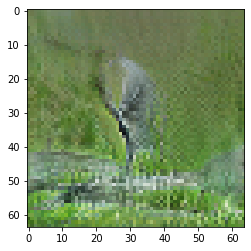

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 6

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.63899564743042 sec
Gen loss: 4.429946714623511, Gen valid loss: 1.27866948103194, Gen attr loss: 1.6016927618321364, Gen caption loss: 1.5495844769284008, Disc valid loss: 1.084068002093452, Disc valid real loss: 0.5629841659450272, Disc valid fake loss: 0.5210838385309954, Disc attr loss: 3.129807618252307, Disc attr real loss: 1.5281148564201708, Disc attr fake loss: 1.6016927618321364
Time for epoch 2 is 38.41229796409607 sec
Gen loss: 4.380142030354115, Gen valid loss: 1.2334311754722906, Gen attr loss: 1.6001660029093425, Gen caption loss: 1.5465448493879985, Disc valid loss: 1.1008118206892556, Disc valid real loss: 0.5732760750019776, Disc valid fake loss: 0.5275357455257478, Disc attr loss: 3.1284471789026647, Disc attr real loss: 1.5282811759933224, Disc attr fake loss: 1.6001660029093425
Time for epoch 3 is 38.77544569969177 sec
Gen loss: 

Time for epoch 21 is 38.87420439720154 sec
Gen loss: 4.4035087756025115, Gen valid loss: 1.248320056978603, Gen attr loss: 1.603199055201316, Gen caption loss: 1.5519896635841224, Disc valid loss: 1.0940800620934505, Disc valid real loss: 0.5652109306194595, Disc valid fake loss: 0.5288691305048098, Disc attr loss: 3.1305749332355615, Disc attr real loss: 1.5273758780342455, Disc attr fake loss: 1.603199055201316
Time for epoch 22 is 38.47625160217285 sec
Gen loss: 4.3956549710374535, Gen valid loss: 1.2425274894166445, Gen attr loss: 1.6016758215136644, Gen caption loss: 1.5514516565534804, Disc valid loss: 1.0927098222218232, Disc valid real loss: 0.5698502973973912, Disc valid fake loss: 0.5228595260359085, Disc attr loss: 3.12904694894465, Disc attr real loss: 1.5273711274309856, Disc attr fake loss: 1.6016758215136644
Time for epoch 23 is 38.8030149936676 sec
Gen loss: 4.40336448002637, Gen valid loss: 1.2497796450203997, Gen attr loss: 1.6016053907916474, Gen caption loss: 1.5519

Time for epoch 41 is 38.60844087600708 sec
Gen loss: 4.388486868643826, Gen valid loss: 1.250670101745988, Gen attr loss: 1.5959085038683924, Gen caption loss: 1.5419082557605857, Disc valid loss: 1.0871873864636512, Disc valid real loss: 0.562059705900306, Disc valid fake loss: 0.5251276771712109, Disc attr loss: 3.123242918391861, Disc attr real loss: 1.5273344145234684, Disc attr fake loss: 1.5959085038683924
Time for epoch 42 is 38.61163783073425 sec
Gen loss: 4.385789633443362, Gen valid loss: 1.2409654440595528, Gen attr loss: 1.5971018085634805, Gen caption loss: 1.5477223783973757, Disc valid loss: 1.097375599187887, Disc valid real loss: 0.5652334390455468, Disc valid fake loss: 0.5321421603846356, Disc attr loss: 3.1242468050178798, Disc attr real loss: 1.527144996454399, Disc attr fake loss: 1.5971018085634805
Time for epoch 43 is 38.66025447845459 sec
Gen loss: 4.382956256065265, Gen valid loss: 1.2335327109347192, Gen attr loss: 1.6003086043567192, Gen caption loss: 1.5491

Time for epoch 61 is 38.65842008590698 sec
Gen loss: 4.394449754782163, Gen valid loss: 1.240553808729177, Gen attr loss: 1.6001545420184045, Gen caption loss: 1.5537413972503125, Disc valid loss: 1.0988670081950138, Disc valid real loss: 0.5668924177888286, Disc valid fake loss: 0.5319745901638899, Disc attr loss: 3.1271316178122834, Disc attr real loss: 1.5269770757938788, Disc attr fake loss: 1.6001545420184045
Time for epoch 62 is 39.1018705368042 sec
Gen loss: 4.393508850397456, Gen valid loss: 1.2463342213049167, Gen attr loss: 1.598240702455929, Gen caption loss: 1.5489339259904897, Disc valid loss: 1.0941729167612588, Disc valid real loss: 0.5635962381272458, Disc valid fake loss: 0.530576681056966, Disc attr loss: 3.1247102209546056, Disc attr real loss: 1.5264695184986765, Disc attr fake loss: 1.598240702455929
Time for epoch 63 is 38.674699783325195 sec
Gen loss: 4.385658948402095, Gen valid loss: 1.2360336224884199, Gen attr loss: 1.6029289401966704, Gen caption loss: 1.546

Time for epoch 81 is 38.42271304130554 sec
Gen loss: 4.397042883767022, Gen valid loss: 1.245649423379562, Gen attr loss: 1.60199578829251, Gen caption loss: 1.5493976743563727, Disc valid loss: 1.0938044678228012, Disc valid real loss: 0.5660440922591098, Disc valid fake loss: 0.5277603758059866, Disc attr loss: 3.1280382629332504, Disc attr real loss: 1.5260424746407404, Disc attr fake loss: 1.60199578829251
Time for epoch 82 is 38.76554226875305 sec
Gen loss: 4.399773198414624, Gen valid loss: 1.2501891583285034, Gen attr loss: 1.5996771133365992, Gen caption loss: 1.5499069186730114, Disc valid loss: 1.0822764925840425, Disc valid real loss: 0.5580846089819259, Disc valid fake loss: 0.524191885621244, Disc attr loss: 3.124955338514271, Disc attr real loss: 1.5252782251776718, Disc attr fake loss: 1.5996771133365992
Time for epoch 83 is 38.32660531997681 sec
Gen loss: 4.389408794521962, Gen valid loss: 1.2399455987341035, Gen attr loss: 1.5998112005269947, Gen caption loss: 1.549652

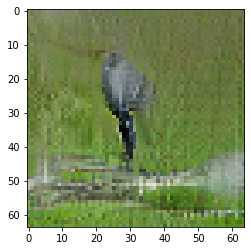

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 7

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.29521822929382 sec
Gen loss: 4.396862489421193, Gen valid loss: 1.24665610706257, Gen attr loss: 1.6006892367107113, Gen caption loss: 1.5495171456479122, Disc valid loss: 1.0909559865631062, Disc valid real loss: 0.5629794698582109, Disc valid fake loss: 0.5279765154934188, Disc attr loss: 3.1252661116401033, Disc attr real loss: 1.524576874929392, Disc attr fake loss: 1.6006892367107113
Time for epoch 2 is 38.58215832710266 sec
Gen loss: 4.385831044618353, Gen valid loss: 1.2421083308170804, Gen attr loss: 1.5988867299020453, Gen caption loss: 1.5448359771149591, Disc valid loss: 1.0954499965114646, Disc valid real loss: 0.5668437875060208, Disc valid fake loss: 0.5286062109438061, Disc attr loss: 3.1238086304367396, Disc attr real loss: 1.5249219005346943, Disc attr fake loss: 1.5988867299020453
Time for epoch 3 is 38.668360471725464 sec
Gen loss

Time for epoch 21 is 38.89797759056091 sec
Gen loss: 4.395707719048187, Gen valid loss: 1.2426578643199229, Gen attr loss: 1.6028761660180442, Gen caption loss: 1.5501736854796164, Disc valid loss: 1.0965753559497637, Disc valid real loss: 0.5644565017081211, Disc valid fake loss: 0.5321188535955217, Disc attr loss: 3.127629199648291, Disc attr real loss: 1.524753033630247, Disc attr fake loss: 1.6028761660180442
Time for epoch 22 is 38.889002561569214 sec
Gen loss: 4.391537409164719, Gen valid loss: 1.247049535677685, Gen attr loss: 1.5962985876776015, Gen caption loss: 1.5481893034162237, Disc valid loss: 1.0914108449527564, Disc valid real loss: 0.5599412889015384, Disc valid fake loss: 0.5314695579088154, Disc attr loss: 3.1207418015332724, Disc attr real loss: 1.524443213855671, Disc attr fake loss: 1.5962985876776015
Time for epoch 23 is 38.87207841873169 sec
Gen loss: 4.399447728624835, Gen valid loss: 1.254424559391611, Gen attr loss: 1.5979361298284556, Gen caption loss: 1.547

Time for epoch 41 is 38.918920278549194 sec
Gen loss: 4.398014094448348, Gen valid loss: 1.2438153015565743, Gen attr loss: 1.6023262480733194, Gen caption loss: 1.5518725635559578, Disc valid loss: 1.092603329882066, Disc valid real loss: 0.5653888854554029, Disc valid fake loss: 0.5272144441843679, Disc attr loss: 3.1256422285788106, Disc attr real loss: 1.523315980505491, Disc attr fake loss: 1.6023262480733194
Time for epoch 42 is 38.98876595497131 sec
Gen loss: 4.389269415925189, Gen valid loss: 1.2397114555364055, Gen attr loss: 1.6006159320433289, Gen caption loss: 1.5489420212381255, Disc valid loss: 1.0911295837180077, Disc valid real loss: 0.5587517346146953, Disc valid fake loss: 0.5323778521723863, Disc attr loss: 3.1245096857308696, Disc attr real loss: 1.5238937536875408, Disc attr fake loss: 1.6006159320433289
Time for epoch 43 is 38.922911167144775 sec
Gen loss: 4.395575150564757, Gen valid loss: 1.2457616933316074, Gen attr loss: 1.6035810053187012, Gen caption loss: 1

Time for epoch 61 is 38.59708881378174 sec
Gen loss: 4.388941340976292, Gen valid loss: 1.2411307256396225, Gen attr loss: 1.5997145398845518, Gen caption loss: 1.548096073029164, Disc valid loss: 1.0984133932648636, Disc valid real loss: 0.5656024839496872, Disc valid fake loss: 0.5328109079421697, Disc attr loss: 3.122080604881452, Disc attr real loss: 1.5223660649969002, Disc attr fake loss: 1.5997145398845518
Time for epoch 62 is 38.6615309715271 sec
Gen loss: 4.393608344602714, Gen valid loss: 1.2455989590828336, Gen attr loss: 1.600045980799812, Gen caption loss: 1.5479634111812768, Disc valid loss: 1.0862554053303994, Disc valid real loss: 0.5602517186141596, Disc valid fake loss: 0.5260036893007232, Disc attr loss: 3.1220969016635967, Disc attr real loss: 1.5220509208637847, Disc attr fake loss: 1.600045980799812
Time for epoch 63 is 38.430909156799316 sec
Gen loss: 4.392171027537607, Gen valid loss: 1.2462836421602141, Gen attr loss: 1.59952096693561, Gen caption loss: 1.54636

Time for epoch 81 is 38.43464422225952 sec
Gen loss: 4.39170414322437, Gen valid loss: 1.243667649867412, Gen attr loss: 1.6012382743158315, Gen caption loss: 1.5467982137106298, Disc valid loss: 1.0928285278602021, Disc valid real loss: 0.5655899463791835, Disc valid fake loss: 0.5272385839847368, Disc attr loss: 3.122898797032633, Disc attr real loss: 1.5216605227168014, Disc attr fake loss: 1.6012382743158315
Time for epoch 82 is 38.42838954925537 sec
Gen loss: 4.3812118429478595, Gen valid loss: 1.2359998418386713, Gen attr loss: 1.598311132531825, Gen caption loss: 1.5469008771384634, Disc valid loss: 1.0976759528079976, Disc valid real loss: 0.566444456496536, Disc valid fake loss: 0.5312314958268711, Disc attr loss: 3.1203054451360934, Disc attr real loss: 1.5219943126042683, Disc attr fake loss: 1.598311132531825
Time for epoch 83 is 38.46880102157593 sec
Gen loss: 4.408805011733761, Gen valid loss: 1.2575204377251912, Gen attr loss: 1.6034668506322514, Gen caption loss: 1.5478

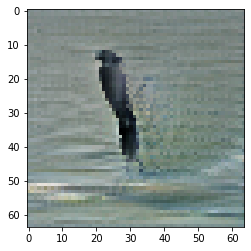

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 8

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.43440532684326 sec
Gen loss: 4.401967648891253, Gen valid loss: 1.2572875597935704, Gen attr loss: 1.5979666073470904, Gen caption loss: 1.546713483688954, Disc valid loss: 1.0903973503487543, Disc valid real loss: 0.5635174017773088, Disc valid fake loss: 0.5268799484906804, Disc attr loss: 3.1188043924528084, Disc attr real loss: 1.5208377851057182, Disc attr fake loss: 1.5979666073470904
Time for epoch 2 is 38.36082601547241 sec
Gen loss: 4.412552851002391, Gen valid loss: 1.264198900076755, Gen attr loss: 1.5980090122558883, Gen caption loss: 1.5503449517536938, Disc valid loss: 1.0825913086493164, Disc valid real loss: 0.5525298101630637, Disc valid fake loss: 0.5300615008284406, Disc attr loss: 3.1189249886406794, Disc attr real loss: 1.520915976384791, Disc attr fake loss: 1.5980090122558883
Time for epoch 3 is 38.39729309082031 sec
Gen loss:

Time for epoch 21 is 38.34210968017578 sec
Gen loss: 4.392237982452723, Gen valid loss: 1.2480282098620241, Gen attr loss: 1.598052114329041, Gen caption loss: 1.5461576560002355, Disc valid loss: 1.0998308928355292, Disc valid real loss: 0.5650466896977205, Disc valid fake loss: 0.5347842023301577, Disc attr loss: 3.11870531208793, Disc attr real loss: 1.520653197758889, Disc attr fake loss: 1.598052114329041
Time for epoch 22 is 38.39747929573059 sec
Gen loss: 4.403073986048298, Gen valid loss: 1.2533048693403641, Gen attr loss: 1.6018888730666825, Gen caption loss: 1.5478802405721772, Disc valid loss: 1.0882169286086953, Disc valid real loss: 0.5589758977495881, Disc valid fake loss: 0.5292410308591072, Disc attr loss: 3.1222975212060984, Disc attr real loss: 1.5204086481394161, Disc attr fake loss: 1.6018888730666825
Time for epoch 23 is 38.36811327934265 sec
Gen loss: 4.401109860195377, Gen valid loss: 1.248199848624749, Gen attr loss: 1.6011495289763784, Gen caption loss: 1.55176

Time for epoch 41 is 38.43168568611145 sec
Gen loss: 4.38731446692614, Gen valid loss: 1.2368753757580186, Gen attr loss: 1.599688293488045, Gen caption loss: 1.550750800910681, Disc valid loss: 1.0991837723145317, Disc valid real loss: 0.566044541151543, Disc valid fake loss: 0.5331392333436464, Disc attr loss: 3.119282514745304, Disc attr real loss: 1.5195942212572588, Disc attr fake loss: 1.599688293488045
Time for epoch 42 is 38.498403787612915 sec
Gen loss: 4.3846312770998574, Gen valid loss: 1.2479617187001195, Gen attr loss: 1.5929834862065508, Gen caption loss: 1.5436860668626904, Disc valid loss: 1.0942505670756828, Disc valid real loss: 0.5667441415431377, Disc valid fake loss: 0.5275064248056592, Disc attr loss: 3.112863310953466, Disc attr real loss: 1.519879824746915, Disc attr fake loss: 1.5929834862065508
Time for epoch 43 is 38.43388080596924 sec
Gen loss: 4.399979170744981, Gen valid loss: 1.2516320226638298, Gen attr loss: 1.6003843801131417, Gen caption loss: 1.54796

Time for epoch 61 is 38.61801242828369 sec
Gen loss: 4.389151903995008, Gen valid loss: 1.2420475020964294, Gen attr loss: 1.5995177605610875, Gen caption loss: 1.5475866445680944, Disc valid loss: 1.0925195650033512, Disc valid real loss: 0.5592524977880442, Disc valid fake loss: 0.5332670653577096, Disc attr loss: 3.1189368572338485, Disc attr real loss: 1.519419096672761, Disc attr fake loss: 1.5995177605610875
Time for epoch 62 is 38.56829047203064 sec
Gen loss: 4.402512605274273, Gen valid loss: 1.2492396522989764, Gen attr loss: 1.6022814134272134, Gen caption loss: 1.5509915342175864, Disc valid loss: 1.0909970120039736, Disc valid real loss: 0.5648823515347995, Disc valid fake loss: 0.5261146603076439, Disc attr loss: 3.121202043724577, Disc attr real loss: 1.5189206302973637, Disc attr fake loss: 1.6022814134272134
Time for epoch 63 is 38.53785800933838 sec
Gen loss: 4.395695794888629, Gen valid loss: 1.2553993860880535, Gen attr loss: 1.594246517028912, Gen caption loss: 1.54

Time for epoch 81 is 38.52943181991577 sec
Gen loss: 4.404399475754115, Gen valid loss: 1.2584036268839023, Gen attr loss: 1.5967207074488405, Gen caption loss: 1.549275135606285, Disc valid loss: 1.0963850300809554, Disc valid real loss: 0.5641107881456856, Disc valid fake loss: 0.5322742417737397, Disc attr loss: 3.114163990266278, Disc attr real loss: 1.5174432828174373, Disc attr fake loss: 1.5967207074488405
Time for epoch 82 is 38.53595042228699 sec
Gen loss: 4.374140479700352, Gen valid loss: 1.2360541831833238, Gen attr loss: 1.595028738019266, Gen caption loss: 1.5430575560748092, Disc valid loss: 1.0991653470489067, Disc valid real loss: 0.5659471394892953, Disc valid fake loss: 0.5332182052981885, Disc attr loss: 3.1124354197080866, Disc attr real loss: 1.5174066816888205, Disc attr fake loss: 1.595028738019266
Time for epoch 83 is 38.56245541572571 sec
Gen loss: 4.385022336551491, Gen valid loss: 1.2448448708386926, Gen attr loss: 1.5960348146717722, Gen caption loss: 1.544

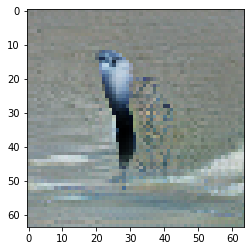

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 9

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.16873335838318 sec
Gen loss: 4.402171713226856, Gen valid loss: 1.2559562191407532, Gen attr loss: 1.5982106843291906, Gen caption loss: 1.5480048036187646, Disc valid loss: 1.09514696924344, Disc valid real loss: 0.5628653506276408, Disc valid fake loss: 0.5322816197465106, Disc attr loss: 3.1147842736748177, Disc attr real loss: 1.5165735893456271, Disc attr fake loss: 1.5982106843291906
Time for epoch 2 is 38.569923877716064 sec
Gen loss: 4.409707434455231, Gen valid loss: 1.2635922546632246, Gen attr loss: 1.5985995298478661, Gen caption loss: 1.547515649136489, Disc valid loss: 1.0811801735301652, Disc valid real loss: 0.5516739183163578, Disc valid fake loss: 0.5295062520639683, Disc attr loss: 3.115284442578551, Disc attr real loss: 1.5166849127306847, Disc attr fake loss: 1.5985995298478661
Time for epoch 3 is 38.53515315055847 sec
Gen loss:

Time for epoch 21 is 38.51801657676697 sec
Gen loss: 4.410613534250234, Gen valid loss: 1.2636727784384234, Gen attr loss: 1.598635877374065, Gen caption loss: 1.5483048740764298, Disc valid loss: 1.0909868528849387, Disc valid real loss: 0.5613702682621757, Disc valid fake loss: 0.5296165850265886, Disc attr loss: 3.1145424271017554, Disc attr real loss: 1.5159065497276907, Disc attr fake loss: 1.598635877374065
Time for epoch 22 is 38.43851041793823 sec
Gen loss: 4.414939058505423, Gen valid loss: 1.2555457032146815, Gen attr loss: 1.6042103382953137, Gen caption loss: 1.5551829893737628, Disc valid loss: 1.091001124724463, Disc valid real loss: 0.5622457171358713, Disc valid fake loss: 0.5287554097692495, Disc attr loss: 3.1197675831595735, Disc attr real loss: 1.5155572448642596, Disc attr fake loss: 1.6042103382953137
Time for epoch 23 is 38.553349018096924 sec
Gen loss: 4.4025204730873835, Gen valid loss: 1.2535377041434208, Gen attr loss: 1.596356715290204, Gen caption loss: 1.5

Time for epoch 41 is 38.56116080284119 sec
Gen loss: 4.407274926581034, Gen valid loss: 1.2575250402052551, Gen attr loss: 1.6004786371861692, Gen caption loss: 1.5492712430514617, Disc valid loss: 1.0918496367408008, Disc valid real loss: 0.55881740471858, Disc valid fake loss: 0.5330322315376302, Disc attr loss: 3.1151747031586603, Disc attr real loss: 1.514696065972491, Disc attr fake loss: 1.6004786371861692
Time for epoch 42 is 38.60118770599365 sec
Gen loss: 4.391908537081586, Gen valid loss: 1.2462431276393777, Gen attr loss: 1.5995966280055887, Gen caption loss: 1.5460687791751975, Disc valid loss: 1.0884457689313707, Disc valid real loss: 0.5580832101303711, Disc valid fake loss: 0.5303625602547716, Disc attr loss: 3.114624837549721, Disc attr real loss: 1.5150282095441328, Disc attr fake loss: 1.5995966280055887
Time for epoch 43 is 38.57123279571533 sec
Gen loss: 4.401933879387088, Gen valid loss: 1.2569699012813207, Gen attr loss: 1.5946666512709, Gen caption loss: 1.550297

Time for epoch 61 is 38.489627838134766 sec
Gen loss: 4.3886467163478775, Gen valid loss: 1.242436992443674, Gen attr loss: 1.5970311155164145, Gen caption loss: 1.5491786174334807, Disc valid loss: 1.0974277509906427, Disc valid real loss: 0.562154316401417, Disc valid fake loss: 0.5352734354776418, Disc attr loss: 3.1114258333273375, Disc attr real loss: 1.514394717810923, Disc attr fake loss: 1.5970311155164145
Time for epoch 62 is 38.52416968345642 sec
Gen loss: 4.3916871276328235, Gen valid loss: 1.2484250722861872, Gen attr loss: 1.5950372542146098, Gen caption loss: 1.5482247945092882, Disc valid loss: 1.0938160700526665, Disc valid real loss: 0.5594317321047227, Disc valid fake loss: 0.5343843391594202, Disc attr loss: 3.1088534060532487, Disc attr real loss: 1.5138161518386386, Disc attr fake loss: 1.5950372542146098
Time for epoch 63 is 38.496166467666626 sec
Gen loss: 4.40031008474872, Gen valid loss: 1.2573666286662342, Gen attr loss: 1.5973786028420054, Gen caption loss: 1

Time for epoch 81 is 38.468435525894165 sec
Gen loss: 4.3886251068373685, Gen valid loss: 1.2507701259318407, Gen attr loss: 1.5953737897924614, Gen caption loss: 1.5424812024201804, Disc valid loss: 1.0884062126076965, Disc valid real loss: 0.5608208823171734, Disc valid fake loss: 0.5275853319865901, Disc attr loss: 3.1084591214895894, Disc attr real loss: 1.513085331697128, Disc attr fake loss: 1.5953737897924614
Time for epoch 82 is 38.52382183074951 sec
Gen loss: 4.402440002617151, Gen valid loss: 1.2587227674357613, Gen attr loss: 1.5981134505775887, Gen caption loss: 1.5456037744273985, Disc valid loss: 1.0875427041273453, Disc valid real loss: 0.55655726661204, Disc valid fake loss: 0.530985439695963, Disc attr loss: 3.1111593059084925, Disc attr real loss: 1.513045855330904, Disc attr fake loss: 1.5981134505775887
Time for epoch 83 is 38.47028470039368 sec
Gen loss: 4.392874416620105, Gen valid loss: 1.2524910588574603, Gen attr loss: 1.5951809986497005, Gen caption loss: 1.54

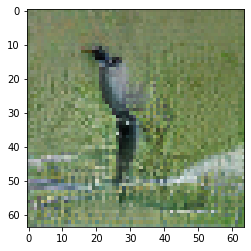

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 10

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.189796686172485 sec
Gen loss: 4.4021838208847255, Gen valid loss: 1.2552644668555841, Gen attr loss: 1.599926604811092, Gen caption loss: 1.5469927487334585, Disc valid loss: 1.097067073754825, Disc valid real loss: 0.5667727872285093, Disc valid fake loss: 0.5302942846687182, Disc attr loss: 3.112305535533564, Disc attr real loss: 1.5123789307224718, Disc attr fake loss: 1.599926604811092
Time for epoch 2 is 38.56238412857056 sec
Gen loss: 4.4161428920621795, Gen valid loss: 1.2660307628998588, Gen attr loss: 1.5988246318770618, Gen caption loss: 1.5512874995466817, Disc valid loss: 1.0897989987034784, Disc valid real loss: 0.5591085924688717, Disc valid fake loss: 0.5306904046193048, Disc attr loss: 3.112076782598728, Disc attr real loss: 1.5132521507216663, Disc attr fake loss: 1.5988246318770618
Time for epoch 3 is 38.53660583496094 sec
Gen los

Time for epoch 21 is 38.25661849975586 sec
Gen loss: 4.405667630637565, Gen valid loss: 1.2578625147581746, Gen attr loss: 1.5993228236511148, Gen caption loss: 1.548482287543899, Disc valid loss: 1.0947990535397516, Disc valid real loss: 0.5627698686710865, Disc valid fake loss: 0.5320291835764236, Disc attr loss: 3.110509135535739, Disc attr real loss: 1.5111863118846243, Disc attr fake loss: 1.5993228236511148
Time for epoch 22 is 38.53567552566528 sec
Gen loss: 4.391412942390132, Gen valid loss: 1.2523338279426905, Gen attr loss: 1.593879391830465, Gen caption loss: 1.5451997140558755, Disc valid loss: 1.0903817192325747, Disc valid real loss: 0.5610480657437953, Disc valid fake loss: 0.5293336532464842, Disc attr loss: 3.1054670248574356, Disc attr real loss: 1.5115876330269709, Disc attr fake loss: 1.593879391830465
Time for epoch 23 is 38.48063349723816 sec
Gen loss: 4.423497040420367, Gen valid loss: 1.262315651104056, Gen attr loss: 1.6060352661422275, Gen caption loss: 1.5551

Time for epoch 41 is 38.35348582267761 sec
Gen loss: 4.398776292154783, Gen valid loss: 1.2493929858130168, Gen attr loss: 1.5999459393302276, Gen caption loss: 1.54943735263535, Disc valid loss: 1.0990229996885388, Disc valid real loss: 0.5666365870615331, Disc valid fake loss: 0.5323864136769519, Disc attr loss: 3.1101202470500295, Disc attr real loss: 1.5101743077198018, Disc attr fake loss: 1.5999459393302276
Time for epoch 42 is 38.417611837387085 sec
Gen loss: 4.394951946367093, Gen valid loss: 1.2557317753471333, Gen attr loss: 1.5946094585951105, Gen caption loss: 1.544610706448232, Disc valid loss: 1.0918099245404809, Disc valid real loss: 0.5588520568237718, Disc valid fake loss: 0.5329578656168165, Disc attr loss: 3.104919309215494, Disc attr real loss: 1.5103098506203836, Disc attr fake loss: 1.5946094585951105
Time for epoch 43 is 38.387539863586426 sec
Gen loss: 4.380475088186704, Gen valid loss: 1.236216206860736, Gen attr loss: 1.5959530119004288, Gen caption loss: 1.54

Time for epoch 61 is 38.35818028450012 sec
Gen loss: 4.4150348000410125, Gen valid loss: 1.2675332003815711, Gen attr loss: 1.5996258549573945, Gen caption loss: 1.5478757426021545, Disc valid loss: 1.086959443925842, Disc valid real loss: 0.5580686996299723, Disc valid fake loss: 0.5288907447804604, Disc attr loss: 3.1090382340800793, Disc attr real loss: 1.509412379122685, Disc attr fake loss: 1.5996258549573945
Time for epoch 62 is 38.37663817405701 sec
Gen loss: 4.401587165145047, Gen valid loss: 1.257322792761371, Gen attr loss: 1.596045386500475, Gen caption loss: 1.5482189803911741, Disc valid loss: 1.091482170552096, Disc valid real loss: 0.5602307437558162, Disc valid fake loss: 0.5312514242117967, Disc attr loss: 3.1050138059993424, Disc attr real loss: 1.5089684194988675, Disc attr fake loss: 1.596045386500475
Time for epoch 63 is 38.40881037712097 sec
Gen loss: 4.390182152027037, Gen valid loss: 1.2484256870701385, Gen attr loss: 1.5960933070195722, Gen caption loss: 1.5456

Time for epoch 81 is 38.396034717559814 sec
Gen loss: 4.395502423206319, Gen valid loss: 1.2515488559314552, Gen attr loss: 1.5976775622949368, Gen caption loss: 1.5462759956111753, Disc valid loss: 1.0958452488025676, Disc valid real loss: 0.5600049573231519, Disc valid fake loss: 0.535840287764221, Disc attr loss: 3.1060447088748138, Disc attr real loss: 1.508367146579877, Disc attr fake loss: 1.5976775622949368
Time for epoch 82 is 38.71038293838501 sec
Gen loss: 4.391610855655618, Gen valid loss: 1.2436695811225147, Gen attr loss: 1.5981028448275434, Gen caption loss: 1.5498384376205403, Disc valid loss: 1.0981246388055446, Disc valid real loss: 0.5631100356901887, Disc valid fake loss: 0.5350146012577585, Disc attr loss: 3.1065188203723775, Disc attr real loss: 1.5084159755448339, Disc attr fake loss: 1.5981028448275434
Time for epoch 83 is 38.23451352119446 sec
Gen loss: 4.398549485012768, Gen valid loss: 1.2463011864401137, Gen attr loss: 1.601640846994188, Gen caption loss: 1.5

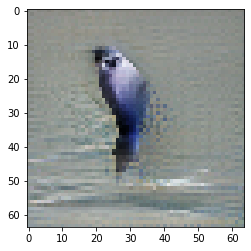

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 11

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.425867319107056 sec
Gen loss: 4.381974728126836, Gen valid loss: 1.237874355904132, Gen attr loss: 1.596943271515492, Gen caption loss: 1.5471571060377085, Disc valid loss: 1.1052096910916047, Disc valid real loss: 0.564928526477762, Disc valid fake loss: 0.5402811654214936, Disc attr loss: 3.103761384803751, Disc attr real loss: 1.5068181132882592, Disc attr fake loss: 1.596943271515492
Time for epoch 2 is 38.761667013168335 sec
Gen loss: 4.410437298984062, Gen valid loss: 1.262938186566681, Gen attr loss: 1.6003864247624466, Gen caption loss: 1.547112691047069, Disc valid loss: 1.0854987791237147, Disc valid real loss: 0.5566408303048875, Disc valid fake loss: 0.5288579459920485, Disc attr loss: 3.1082126422303156, Disc attr real loss: 1.507826217467869, Disc attr fake loss: 1.6003864247624466
Time for epoch 3 is 38.34052753448486 sec
Gen loss: 4

Time for epoch 21 is 38.60996055603027 sec
Gen loss: 4.386149440677508, Gen valid loss: 1.2459433800805875, Gen attr loss: 1.5951416288934104, Gen caption loss: 1.5450644241115912, Disc valid loss: 1.1019342236402558, Disc valid real loss: 0.5655163231742414, Disc valid fake loss: 0.5364179011121352, Disc attr loss: 3.1022231866350665, Disc attr real loss: 1.5070815577416563, Disc attr fake loss: 1.5951416288934104
Time for epoch 22 is 38.66465353965759 sec
Gen loss: 4.38563800439602, Gen valid loss: 1.2458714529427732, Gen attr loss: 1.596349640913449, Gen caption loss: 1.543416906824603, Disc valid loss: 1.094677600434156, Disc valid real loss: 0.5648642905197816, Disc valid fake loss: 0.5298133092682537, Disc attr loss: 3.102617677957385, Disc attr real loss: 1.5062680370439359, Disc attr fake loss: 1.596349640913449
Time for epoch 23 is 38.64180827140808 sec
Gen loss: 4.400384147638874, Gen valid loss: 1.2524436909331862, Gen attr loss: 1.5986144306859995, Gen caption loss: 1.54932

Time for epoch 41 is 38.652830839157104 sec
Gen loss: 4.381692995546956, Gen valid loss: 1.2409710927707394, Gen attr loss: 1.596605112559104, Gen caption loss: 1.5441167742256228, Disc valid loss: 1.0991942162113137, Disc valid real loss: 0.5609937206031831, Disc valid fake loss: 0.5382004979503187, Disc attr loss: 3.1023983128348664, Disc attr real loss: 1.5057932002757624, Disc attr fake loss: 1.596605112559104
Time for epoch 42 is 38.59816312789917 sec
Gen loss: 4.389103642647182, Gen valid loss: 1.248362300841789, Gen attr loss: 1.5961705152258316, Gen caption loss: 1.544570813980206, Disc valid loss: 1.0911748966550439, Disc valid real loss: 0.5574690406400014, Disc valid fake loss: 0.5337058542382104, Disc attr loss: 3.101330092282799, Disc attr real loss: 1.5051595770569675, Disc attr fake loss: 1.5961705152258316
Time for epoch 43 is 38.590972661972046 sec
Gen loss: 4.400573410638949, Gen valid loss: 1.254124936211077, Gen attr loss: 1.598147271771418, Gen caption loss: 1.5483

Time for epoch 61 is 38.61522388458252 sec
Gen loss: 4.3942913072219065, Gen valid loss: 1.2499648298674482, Gen attr loss: 1.5971518616043132, Gen caption loss: 1.54717461203495, Disc valid loss: 1.0975105192280075, Disc valid real loss: 0.5588154856590074, Disc valid fake loss: 0.5386950362342483, Disc attr loss: 3.1013537331971373, Disc attr real loss: 1.504201871592824, Disc attr fake loss: 1.5971518616043132
Time for epoch 62 is 38.57843255996704 sec
Gen loss: 4.398884111626685, Gen valid loss: 1.2534760508110854, Gen attr loss: 1.5966921188643954, Gen caption loss: 1.5487159461509892, Disc valid loss: 1.092973709591036, Disc valid real loss: 0.5607057897863672, Disc valid fake loss: 0.5322679188354875, Disc attr loss: 3.101356090891975, Disc attr real loss: 1.5046639720275796, Disc attr fake loss: 1.5966921188643954
Time for epoch 63 is 38.61853241920471 sec
Gen loss: 4.400280412296616, Gen valid loss: 1.2626974875041785, Gen attr loss: 1.5925702124753296, Gen caption loss: 1.545

Time for epoch 81 is 38.81941866874695 sec
Gen loss: 4.385351043406541, Gen valid loss: 1.2420768732947063, Gen attr loss: 1.5994479300853037, Gen caption loss: 1.5438262363113362, Disc valid loss: 1.1017570032013788, Disc valid real loss: 0.5621871687370911, Disc valid fake loss: 0.5395698366449454, Disc attr loss: 3.1033539513585366, Disc attr real loss: 1.5039060212732331, Disc attr fake loss: 1.5994479300853037
Time for epoch 82 is 38.80080056190491 sec
Gen loss: 4.389299374608813, Gen valid loss: 1.2481705518918955, Gen attr loss: 1.5955081364003623, Gen caption loss: 1.5456206834090112, Disc valid loss: 1.097222951369557, Disc valid real loss: 0.5616528917618884, Disc valid fake loss: 0.5355700603345546, Disc attr loss: 3.0988519792634297, Disc attr real loss: 1.5033438428630674, Disc attr fake loss: 1.5955081364003623
Time for epoch 83 is 38.816291093826294 sec
Gen loss: 4.400949586697711, Gen valid loss: 1.2586777426686067, Gen attr loss: 1.5974123671772034, Gen caption loss: 1

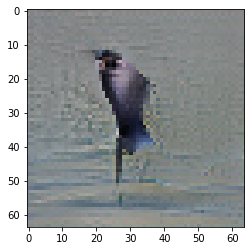

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 12

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.81922674179077 sec
Gen loss: 4.390199302657833, Gen valid loss: 1.2579402382457805, Gen attr loss: 1.590708366254481, Gen caption loss: 1.5415506857197459, Disc valid loss: 1.095964751107906, Disc valid real loss: 0.5611566013598507, Disc valid fake loss: 0.5348081507172365, Disc attr loss: 3.0935141096916303, Disc attr real loss: 1.5028057434371493, Disc attr fake loss: 1.590708366254481
Time for epoch 2 is 38.61236047744751 sec
Gen loss: 4.419888002762627, Gen valid loss: 1.2779660992183013, Gen attr loss: 1.5954755951718587, Gen caption loss: 1.5464463172566276, Disc valid loss: 1.081827542323084, Disc valid real loss: 0.5550806120159181, Disc valid fake loss: 0.5267469305494613, Disc attr loss: 3.097946823450931, Disc attr real loss: 1.5024712282790724, Disc attr fake loss: 1.5954755951718587
Time for epoch 3 is 39.12006735801697 sec
Gen loss: 

Time for epoch 21 is 38.894219160079956 sec
Gen loss: 4.381818613062706, Gen valid loss: 1.2451318794795814, Gen attr loss: 1.5924086667657869, Gen caption loss: 1.5442780679480492, Disc valid loss: 1.0985615377826743, Disc valid real loss: 0.5611077619761955, Disc valid fake loss: 0.5374537735450559, Disc attr loss: 3.0939361467594053, Disc attr real loss: 1.5015274799936187, Disc attr fake loss: 1.5924086667657869
Time for epoch 22 is 39.04917335510254 sec
Gen loss: 4.397856167661465, Gen valid loss: 1.2615092453271717, Gen attr loss: 1.5935049615901338, Gen caption loss: 1.5428419597749787, Disc valid loss: 1.08839268041497, Disc valid real loss: 0.5542977847219482, Disc valid fake loss: 0.5340948946430755, Disc attr loss: 3.095026199733662, Disc attr real loss: 1.5015212381435281, Disc attr fake loss: 1.5935049615901338
Time for epoch 23 is 39.034892320632935 sec
Gen loss: 4.405463621868351, Gen valid loss: 1.2652133530394494, Gen attr loss: 1.5961598225725375, Gen caption loss: 1.

Time for epoch 41 is 38.797969818115234 sec
Gen loss: 4.399454799124865, Gen valid loss: 1.255560972987798, Gen attr loss: 1.5969597870095313, Gen caption loss: 1.5469340386429453, Disc valid loss: 1.0908983974921993, Disc valid real loss: 0.5566526904984864, Disc valid fake loss: 0.5342457043284646, Disc attr loss: 3.098019311744669, Disc attr real loss: 1.501059524735138, Disc attr fake loss: 1.5969597870095313
Time for epoch 42 is 38.82118344306946 sec
Gen loss: 4.394427301437874, Gen valid loss: 1.248554242335684, Gen attr loss: 1.5973620925169327, Gen caption loss: 1.5485109801537946, Disc valid loss: 1.0963253871535221, Disc valid real loss: 0.5603532663528835, Disc valid fake loss: 0.5359721193468667, Disc attr loss: 3.098124754138109, Disc attr real loss: 1.5007626616211764, Disc attr fake loss: 1.5973620925169327
Time for epoch 43 is 39.06378793716431 sec
Gen loss: 4.402022329449331, Gen valid loss: 1.254584259941649, Gen attr loss: 1.5992471990869621, Gen caption loss: 1.5481

Time for epoch 61 is 39.07573962211609 sec
Gen loss: 4.419534989488803, Gen valid loss: 1.2655682949838922, Gen attr loss: 1.6019922659649113, Gen caption loss: 1.5519744128715702, Disc valid loss: 1.093203817118151, Disc valid real loss: 0.5624843927095253, Disc valid fake loss: 0.5307194237625049, Disc attr loss: 3.1014523393093407, Disc attr real loss: 1.4994600733444297, Disc attr fake loss: 1.6019922659649113
Time for epoch 62 is 39.13421010971069 sec
Gen loss: 4.384190379765622, Gen valid loss: 1.2571155302892856, Gen attr loss: 1.590823218105285, Gen caption loss: 1.536251641870514, Disc valid loss: 1.0938527034873238, Disc valid real loss: 0.5595446435739677, Disc valid fake loss: 0.5343080581365239, Disc attr loss: 3.0909073158977476, Disc attr real loss: 1.5000840977924625, Disc attr fake loss: 1.590823218105285
Time for epoch 63 is 39.07715368270874 sec
Gen loss: 4.401958507574024, Gen valid loss: 1.2627672041011697, Gen attr loss: 1.593849991072161, Gen caption loss: 1.5453

Time for epoch 81 is 39.05773711204529 sec
Gen loss: 4.380944548583612, Gen valid loss: 1.2413695903651436, Gen attr loss: 1.594019925691248, Gen caption loss: 1.5455550404422005, Disc valid loss: 1.10082869122668, Disc valid real loss: 0.5650389738845308, Disc valid fake loss: 0.5357897160499077, Disc attr loss: 3.093009500968747, Disc attr real loss: 1.498989575277499, Disc attr fake loss: 1.594019925691248
Time for epoch 82 is 39.06834864616394 sec
Gen loss: 4.401635611929545, Gen valid loss: 1.2507650800513703, Gen attr loss: 1.6003444256175179, Gen caption loss: 1.55052609333824, Disc valid loss: 1.0920895811341966, Disc valid real loss: 0.5572836005752325, Disc valid fake loss: 0.534805982174266, Disc attr loss: 3.0995484280392405, Disc attr real loss: 1.4992040024217228, Disc attr fake loss: 1.6003444256175179
Time for epoch 83 is 39.12890148162842 sec
Gen loss: 4.390601175587352, Gen valid loss: 1.2527910916785883, Gen attr loss: 1.5957914157934627, Gen caption loss: 1.54201866

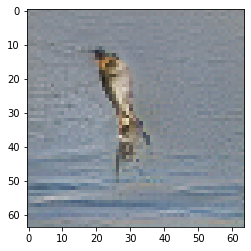

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 13

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 38.87882399559021 sec
Gen loss: 4.401317496286821, Gen valid loss: 1.2609627065942863, Gen attr loss: 1.595483036545234, Gen caption loss: 1.5448717512089385, Disc valid loss: 1.0910223315401775, Disc valid real loss: 0.5594190624832784, Disc valid fake loss: 0.5316032698645501, Disc attr loss: 3.093756092596183, Disc attr real loss: 1.4982730560509494, Disc attr fake loss: 1.595483036545234
Time for epoch 2 is 39.09498071670532 sec
Gen loss: 4.394418618220301, Gen valid loss: 1.2600333566265054, Gen attr loss: 1.592414899570186, Gen caption loss: 1.541970359923717, Disc valid loss: 1.0925546015504253, Disc valid real loss: 0.5596233460153668, Disc valid fake loss: 0.5329312552119981, Disc attr loss: 3.090787036955195, Disc attr real loss: 1.4983721373850092, Disc attr fake loss: 1.592414899570186
Time for epoch 3 is 39.07023334503174 sec
Gen loss: 4.

Time for epoch 21 is 39.02570128440857 sec
Gen loss: 4.391499861792174, Gen valid loss: 1.2503590333429455, Gen attr loss: 1.5963850021362305, Gen caption loss: 1.5447558132290518, Disc valid loss: 1.097325370402194, Disc valid real loss: 0.5614161963062234, Disc valid fake loss: 0.5359091759535678, Disc attr loss: 3.0947906541307444, Disc attr real loss: 1.498405651994514, Disc attr fake loss: 1.5963850021362305
Time for epoch 22 is 39.02342200279236 sec
Gen loss: 4.397981469224139, Gen valid loss: 1.2557333631890253, Gen attr loss: 1.5955565973995178, Gen caption loss: 1.546691509443247, Disc valid loss: 1.093149861830683, Disc valid real loss: 0.558948305483433, Disc valid fake loss: 0.5342015540050621, Disc attr loss: 3.093229147153818, Disc attr real loss: 1.4976725497543004, Disc attr fake loss: 1.5955565973995178
Time for epoch 23 is 39.085819482803345 sec
Gen loss: 4.408598768678784, Gen valid loss: 1.2610437209367107, Gen attr loss: 1.5975565445132371, Gen caption loss: 1.5499

Time for epoch 41 is 39.06081461906433 sec
Gen loss: 4.393627807699891, Gen valid loss: 1.253123626476381, Gen attr loss: 1.5955049374562291, Gen caption loss: 1.5449992499054286, Disc valid loss: 1.1005607958085493, Disc valid real loss: 0.563140195640445, Disc valid fake loss: 0.5374206022679967, Disc attr loss: 3.092564215181966, Disc attr real loss: 1.4970592777257365, Disc attr fake loss: 1.5955049374562291
Time for epoch 42 is 39.01899576187134 sec
Gen loss: 4.394202252390585, Gen valid loss: 1.2592989362998384, Gen attr loss: 1.59362499629902, Gen caption loss: 1.5412783134920487, Disc valid loss: 1.087250866217988, Disc valid real loss: 0.5590381788690562, Disc valid fake loss: 0.5282126858143948, Disc attr loss: 3.0908934226850184, Disc attr real loss: 1.4972684263859983, Disc attr fake loss: 1.59362499629902
Time for epoch 43 is 38.99864935874939 sec
Gen loss: 4.4049192973914835, Gen valid loss: 1.2670128364873126, Gen attr loss: 1.5924118153124966, Gen caption loss: 1.545494

Time for epoch 61 is 39.03247261047363 sec
Gen loss: 4.398050429698252, Gen valid loss: 1.2564272226356878, Gen attr loss: 1.5967086705412, Gen caption loss: 1.5449145286063837, Disc valid loss: 1.089734950201298, Disc valid real loss: 0.5586424746164461, Disc valid fake loss: 0.5310924729196037, Disc attr loss: 3.0936396222127485, Disc attr real loss: 1.4969309516715485, Disc attr fake loss: 1.5967086705412
Time for epoch 62 is 39.020910024642944 sec
Gen loss: 4.394513753694571, Gen valid loss: 1.253491391819021, Gen attr loss: 1.5942001853208878, Gen caption loss: 1.5468221796237356, Disc valid loss: 1.099924181534992, Disc valid real loss: 0.5634513907639315, Disc valid fake loss: 0.5364727870558659, Disc attr loss: 3.0912154244213568, Disc attr real loss: 1.4970152391004692, Disc attr fake loss: 1.5942001853208878
Time for epoch 63 is 39.07826209068298 sec
Gen loss: 4.3846983050266255, Gen valid loss: 1.244036720212559, Gen attr loss: 1.5947087722096016, Gen caption loss: 1.5459528

Time for epoch 81 is 39.10661220550537 sec
Gen loss: 4.398834043725073, Gen valid loss: 1.2656476651103838, Gen attr loss: 1.592238606153142, Gen caption loss: 1.5409477622851446, Disc valid loss: 1.0935391680334965, Disc valid real loss: 0.5589270216178118, Disc valid fake loss: 0.5346121456080336, Disc attr loss: 3.0884109170133183, Disc attr real loss: 1.4961723108601763, Disc attr fake loss: 1.592238606153142
Time for epoch 82 is 39.03405547142029 sec
Gen loss: 4.394637025791778, Gen valid loss: 1.2648478151983038, Gen attr loss: 1.592645892605872, Gen caption loss: 1.537143318633723, Disc valid loss: 1.0864632880784633, Disc valid real loss: 0.5534807570419984, Disc valid fake loss: 0.5329825322479413, Disc attr loss: 3.0884714853472826, Disc attr real loss: 1.4958255927414106, Disc attr fake loss: 1.592645892605872
Time for epoch 83 is 39.02210330963135 sec
Gen loss: 4.403718676993518, Gen valid loss: 1.263364189200931, Gen attr loss: 1.5970635229979104, Gen caption loss: 1.54329

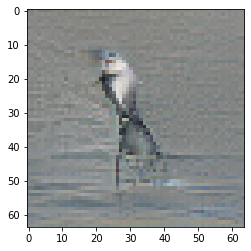

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 14

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.07430672645569 sec
Gen loss: 4.393935854195902, Gen valid loss: 1.255603346075146, Gen attr loss: 1.594564638809783, Gen caption loss: 1.543767872864638, Disc valid loss: 1.0948629994702532, Disc valid real loss: 0.5597910855197648, Disc valid fake loss: 0.5350719126582468, Disc attr loss: 3.090549638277793, Disc attr real loss: 1.49598499946801, Disc attr fake loss: 1.594564638809783
Time for epoch 2 is 38.99172019958496 sec
Gen loss: 4.401515804332123, Gen valid loss: 1.2588771463732733, Gen attr loss: 1.5968137775979392, Gen caption loss: 1.5458248902142533, Disc valid loss: 1.0915170728675718, Disc valid real loss: 0.555155937829961, Disc valid fake loss: 0.5363611361683223, Disc attr loss: 3.09287506971902, Disc attr real loss: 1.4960612921210807, Disc attr fake loss: 1.5968137775979392
Time for epoch 3 is 39.068511724472046 sec
Gen loss: 4.41

Time for epoch 21 is 39.09087252616882 sec
Gen loss: 4.3909136409035865, Gen valid loss: 1.2568707813415423, Gen attr loss: 1.592624530559633, Gen caption loss: 1.5414183275486395, Disc valid loss: 1.102639026435087, Disc valid real loss: 0.5675999729775478, Disc valid fake loss: 0.5350390529729486, Disc attr loss: 3.0878554033393137, Disc attr real loss: 1.4952308727796808, Disc attr fake loss: 1.592624530559633
Time for epoch 22 is 39.05255389213562 sec
Gen loss: 4.389649607624788, Gen valid loss: 1.2552952598427047, Gen attr loss: 1.5909565790558895, Gen caption loss: 1.5433977671108918, Disc valid loss: 1.0947661031552447, Disc valid real loss: 0.5599042224851727, Disc valid fake loss: 0.5348618800239511, Disc attr loss: 3.0858258784301884, Disc attr real loss: 1.4948692993742987, Disc attr fake loss: 1.5909565790558895
Time for epoch 23 is 39.078667402267456 sec
Gen loss: 4.389866514903743, Gen valid loss: 1.247458431294294, Gen attr loss: 1.5951377815670438, Gen caption loss: 1.5

Time for epoch 41 is 39.05072593688965 sec
Gen loss: 4.38884943222935, Gen valid loss: 1.2496822048331986, Gen attr loss: 1.5933789748163405, Gen caption loss: 1.5457882529028708, Disc valid loss: 1.1061189481559484, Disc valid real loss: 0.5646893835164667, Disc valid fake loss: 0.5414295648817771, Disc attr loss: 3.0881263860842076, Disc attr real loss: 1.4947474112678674, Disc attr fake loss: 1.5933789748163405
Time for epoch 42 is 39.02178406715393 sec
Gen loss: 4.3910753319903115, Gen valid loss: 1.2531211710557706, Gen attr loss: 1.593534645672413, Gen caption loss: 1.5444195276999537, Disc valid loss: 1.0893613710636045, Disc valid real loss: 0.559432754267845, Disc valid fake loss: 0.5299286177649407, Disc attr loss: 3.0882375595692375, Disc attr real loss: 1.4947029138968242, Disc attr fake loss: 1.593534645672413
Time for epoch 43 is 39.068002462387085 sec
Gen loss: 4.405273611306498, Gen valid loss: 1.2571210951662968, Gen attr loss: 1.5998738655229894, Gen caption loss: 1.5

Time for epoch 61 is 39.06196880340576 sec
Gen loss: 4.4014468703489635, Gen valid loss: 1.2592418187355932, Gen attr loss: 1.5947758479493097, Gen caption loss: 1.5474292033410009, Disc valid loss: 1.0924303244122968, Disc valid real loss: 0.557373423886493, Disc valid fake loss: 0.5350569028679918, Disc attr loss: 3.088088538588547, Disc attr real loss: 1.4933126906392373, Disc attr fake loss: 1.5947758479493097
Time for epoch 62 is 39.01820945739746 sec
Gen loss: 4.405469301916396, Gen valid loss: 1.2602248543969339, Gen attr loss: 1.5964274080142096, Gen caption loss: 1.5488170398283134, Disc valid loss: 1.095686671695089, Disc valid real loss: 0.5613102019640811, Disc valid fake loss: 0.534376470619424, Disc attr loss: 3.089490379098308, Disc attr real loss: 1.4930629710840986, Disc attr fake loss: 1.5964274080142096
Time for epoch 63 is 39.00832772254944 sec
Gen loss: 4.394819237675447, Gen valid loss: 1.2559588160618211, Gen attr loss: 1.5949122511597507, Gen caption loss: 1.543

Time for epoch 81 is 39.037912130355835 sec
Gen loss: 4.394796304263397, Gen valid loss: 1.2544372559885992, Gen attr loss: 1.5943454268178965, Gen caption loss: 1.5460136237183237, Disc valid loss: 1.0988785836108654, Disc valid real loss: 0.5619254999852116, Disc valid fake loss: 0.5369530820911169, Disc attr loss: 3.086957271183086, Disc attr real loss: 1.4926118443651897, Disc attr fake loss: 1.5943454268178965
Time for epoch 82 is 39.00349521636963 sec
Gen loss: 4.4044502014067115, Gen valid loss: 1.2622510273928242, Gen attr loss: 1.5954244275726277, Gen caption loss: 1.546774732388132, Disc valid loss: 1.0851493865493838, Disc valid real loss: 0.5532684045916973, Disc valid fake loss: 0.5318809815538608, Disc attr loss: 3.088038869666536, Disc attr real loss: 1.4926144420939087, Disc attr fake loss: 1.5954244275726277
Time for epoch 83 is 39.07036352157593 sec
Gen loss: 4.392222009700165, Gen valid loss: 1.259045561639274, Gen attr loss: 1.591913157362279, Gen caption loss: 1.54

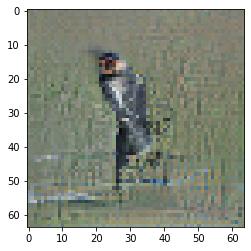

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 15

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.05804753303528 sec
Gen loss: 4.41887597146073, Gen valid loss: 1.2659057096091066, Gen attr loss: 1.600412602347087, Gen caption loss: 1.5525576796958116, Disc valid loss: 1.0937938082831984, Disc valid real loss: 0.5612973822003134, Disc valid fake loss: 0.5324964251944689, Disc attr loss: 3.092176014491859, Disc attr real loss: 1.491763412144772, Disc attr fake loss: 1.600412602347087
Time for epoch 2 is 39.02414345741272 sec
Gen loss: 4.402633444726629, Gen valid loss: 1.269219476356093, Gen attr loss: 1.5919688991737884, Gen caption loss: 1.541445054335969, Disc valid loss: 1.0853882851962475, Disc valid real loss: 0.5537257771181866, Disc valid fake loss: 0.5316625086434166, Disc attr loss: 3.083655336038853, Disc attr real loss: 1.4916864368650649, Disc attr fake loss: 1.5919688991737884
Time for epoch 3 is 39.011555433273315 sec
Gen loss: 4.

Time for epoch 21 is 39.0062198638916 sec
Gen loss: 4.405295467635157, Gen valid loss: 1.2654749466797848, Gen attr loss: 1.5946843103987738, Gen caption loss: 1.5451362168562768, Disc valid loss: 1.0905668549744418, Disc valid real loss: 0.5545042901827391, Disc valid fake loss: 0.5360625668108302, Disc attr loss: 3.0851711348143374, Disc attr real loss: 1.4904868244155636, Disc attr fake loss: 1.5946843103987738
Time for epoch 22 is 39.01979994773865 sec
Gen loss: 4.413127590970295, Gen valid loss: 1.2783718159205222, Gen attr loss: 1.5923069114607524, Gen caption loss: 1.542448875057665, Disc valid loss: 1.0850103125985722, Disc valid real loss: 0.5559169604041712, Disc valid fake loss: 0.5290933533251124, Disc attr loss: 3.082669728493626, Disc attr real loss: 1.4903628170328735, Disc attr fake loss: 1.5923069114607524
Time for epoch 23 is 39.092421531677246 sec
Gen loss: 4.398483622041821, Gen valid loss: 1.2564944049853297, Gen attr loss: 1.594145471487588, Gen caption loss: 1.54

Time for epoch 41 is 39.06141138076782 sec
Gen loss: 4.408724590368711, Gen valid loss: 1.272309372418618, Gen attr loss: 1.5928802141329137, Gen caption loss: 1.5435350025249368, Disc valid loss: 1.0923371495916268, Disc valid real loss: 0.5609151747653155, Disc valid fake loss: 0.5314219740186603, Disc attr loss: 3.082738608848758, Disc attr real loss: 1.4898583947158441, Disc attr fake loss: 1.5928802141329137
Time for epoch 42 is 39.038846015930176 sec
Gen loss: 4.409067312230262, Gen valid loss: 1.2708583845678707, Gen attr loss: 1.593668643052016, Gen caption loss: 1.5445402938175976, Disc valid loss: 1.092544602992412, Disc valid real loss: 0.5591559704080183, Disc valid fake loss: 0.5333886339574002, Disc attr loss: 3.0831759121359847, Disc attr real loss: 1.489507269083969, Disc attr fake loss: 1.593668643052016
Time for epoch 43 is 39.043981075286865 sec
Gen loss: 4.395856097461731, Gen valid loss: 1.2573929047842982, Gen attr loss: 1.5945988893508911, Gen caption loss: 1.543

Time for epoch 61 is 39.01738357543945 sec
Gen loss: 4.391948962276221, Gen valid loss: 1.256912623963705, Gen attr loss: 1.5899805185917593, Gen caption loss: 1.545055819074636, Disc valid loss: 1.0988632261268492, Disc valid real loss: 0.5649526596553927, Disc valid fake loss: 0.5339105653407451, Disc attr loss: 3.078694570032239, Disc attr real loss: 1.4887140514404793, Disc attr fake loss: 1.5899805185917593
Time for epoch 62 is 39.025959968566895 sec
Gen loss: 4.400277204306791, Gen valid loss: 1.260892975459577, Gen attr loss: 1.593135996885739, Gen caption loss: 1.546248239876455, Disc valid loss: 1.0951996923785223, Disc valid real loss: 0.5545681983151733, Disc valid fake loss: 0.5406314926095771, Disc attr loss: 3.0823951894997905, Disc attr real loss: 1.4892591926140515, Disc attr fake loss: 1.593135996885739
Time for epoch 63 is 39.08292531967163 sec
Gen loss: 4.397306459059883, Gen valid loss: 1.2614959509069035, Gen attr loss: 1.5925750031380796, Gen caption loss: 1.54323

Time for epoch 81 is 39.08725428581238 sec
Gen loss: 4.393594761851034, Gen valid loss: 1.2596841580499478, Gen attr loss: 1.5910795952892562, Gen caption loss: 1.542831003504394, Disc valid loss: 1.0992007005182385, Disc valid real loss: 0.5606410882175776, Disc valid fake loss: 0.5385596118968353, Disc attr loss: 3.0796109276412302, Disc attr real loss: 1.488531332351974, Disc attr fake loss: 1.5910795952892562
Time for epoch 82 is 39.055835485458374 sec
Gen loss: 4.4002685999159565, Gen valid loss: 1.2664781795930733, Gen attr loss: 1.592575114270859, Gen caption loss: 1.5412153102518098, Disc valid loss: 1.0863735688734184, Disc valid real loss: 0.5551803523124395, Disc valid fake loss: 0.5311932183378111, Disc attr loss: 3.0807717205063114, Disc attr real loss: 1.4881966062354524, Disc attr fake loss: 1.592575114270859
Time for epoch 83 is 39.47080373764038 sec
Gen loss: 4.383742441652913, Gen valid loss: 1.2533493851258504, Gen attr loss: 1.59047632521084, Gen caption loss: 1.539

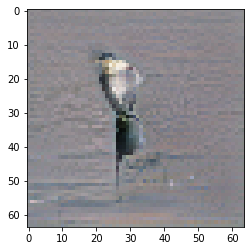

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 16

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.06153988838196 sec
Gen loss: 4.394211911250582, Gen valid loss: 1.2568269632050015, Gen attr loss: 1.593363031462279, Gen caption loss: 1.5440219227214493, Disc valid loss: 1.1047549042598341, Disc valid real loss: 0.5644148428265642, Disc valid fake loss: 0.5403400609486795, Disc attr loss: 3.0808198206469943, Disc attr real loss: 1.487456789184715, Disc attr fake loss: 1.593363031462279
Time for epoch 2 is 39.13740348815918 sec
Gen loss: 4.390341055748586, Gen valid loss: 1.2555313544867808, Gen attr loss: 1.5917019953895715, Gen caption loss: 1.543107707972126, Disc valid loss: 1.0964974098735385, Disc valid real loss: 0.5566834563485329, Disc valid fake loss: 0.5398139532019453, Disc attr loss: 3.0792215271047785, Disc attr real loss: 1.487519531715207, Disc attr fake loss: 1.5917019953895715
Time for epoch 3 is 39.136908292770386 sec
Gen loss:

Time for epoch 21 is 39.3530752658844 sec
Gen loss: 4.409963384876407, Gen valid loss: 1.2659947936773945, Gen attr loss: 1.5983308256480107, Gen caption loss: 1.5456377817040214, Disc valid loss: 1.0958472564614563, Disc valid real loss: 0.5585816811093793, Disc valid fake loss: 0.5372655779365602, Disc attr loss: 3.0852514453696687, Disc attr real loss: 1.4869206197216582, Disc attr fake loss: 1.5983308256480107
Time for epoch 22 is 40.715779542922974 sec
Gen loss: 4.411282094190438, Gen valid loss: 1.2684803039723942, Gen attr loss: 1.594106987562929, Gen caption loss: 1.5486948118623356, Disc valid loss: 1.0850464304288228, Disc valid real loss: 0.5541251072392555, Disc valid fake loss: 0.5309213240779835, Disc attr loss: 3.080686444512551, Disc attr real loss: 1.4865794569496218, Disc attr fake loss: 1.594106987562929
Time for epoch 23 is 40.20950436592102 sec
Gen loss: 4.404500573631225, Gen valid loss: 1.2582610780953716, Gen attr loss: 1.5972464811511156, Gen caption loss: 1.54

Time for epoch 41 is 39.03110384941101 sec
Gen loss: 4.413636000175786, Gen valid loss: 1.2686896716676108, Gen attr loss: 1.5988883968937364, Gen caption loss: 1.546057939529419, Disc valid loss: 1.092421166618988, Disc valid real loss: 0.5609072140723386, Disc valid fake loss: 0.5315139535158308, Disc attr loss: 3.0848218011985304, Disc attr real loss: 1.4859334043047938, Disc attr fake loss: 1.5988883968937364
Time for epoch 42 is 39.0942108631134 sec
Gen loss: 4.404132118070029, Gen valid loss: 1.269968828373162, Gen attr loss: 1.5926474297272804, Gen caption loss: 1.5415158633617205, Disc valid loss: 1.091655599715587, Disc valid real loss: 0.5557807863243227, Disc valid fake loss: 0.535874810079895, Disc attr loss: 3.0788416093604027, Disc attr real loss: 1.4861941796331224, Disc attr fake loss: 1.5926474297272804
Time for epoch 43 is 39.00645709037781 sec
Gen loss: 4.404781636829945, Gen valid loss: 1.2609684212097954, Gen attr loss: 1.595633183714497, Gen caption loss: 1.548180

Time for epoch 61 is 39.142245292663574 sec
Gen loss: 4.38485546809871, Gen valid loss: 1.2581282716779527, Gen attr loss: 1.5899883137162785, Gen caption loss: 1.5367388734972574, Disc valid loss: 1.1021735303124116, Disc valid real loss: 0.5578191942638822, Disc valid fake loss: 0.5443543364523549, Disc attr loss: 3.0753613283963706, Disc attr real loss: 1.4853730146800923, Disc attr fake loss: 1.5899883137162785
Time for epoch 62 is 39.156455755233765 sec
Gen loss: 4.392073460064606, Gen valid loss: 1.2618572732943507, Gen attr loss: 1.5890986951709116, Gen caption loss: 1.5411174791615183, Disc valid loss: 1.0962763929431678, Disc valid real loss: 0.5579563014229462, Disc valid fake loss: 0.5383200932970538, Disc attr loss: 3.073904980811969, Disc attr real loss: 1.4848062856410578, Disc attr fake loss: 1.5890986951709116
Time for epoch 63 is 39.1957631111145 sec
Gen loss: 4.39166533979297, Gen valid loss: 1.2540041697703725, Gen attr loss: 1.5931129688169898, Gen caption loss: 1.5

Time for epoch 81 is 39.14475059509277 sec
Gen loss: 4.389371180598975, Gen valid loss: 1.2553978245755844, Gen attr loss: 1.592172557422462, Gen caption loss: 1.5418008029622436, Disc valid loss: 1.093526220095513, Disc valid real loss: 0.5591388128314237, Disc valid fake loss: 0.5343874069410288, Disc attr loss: 3.076398907961238, Disc attr real loss: 1.4842263505387758, Disc attr fake loss: 1.592172557422462
Time for epoch 82 is 39.19972276687622 sec
Gen loss: 4.402635684827479, Gen valid loss: 1.262403156053083, Gen attr loss: 1.5939094083419014, Gen caption loss: 1.5463231268937025, Disc valid loss: 1.09211291562574, Disc valid real loss: 0.5573963658596442, Disc valid fake loss: 0.534716548958445, Disc attr loss: 3.0782182446017177, Disc attr real loss: 1.484308836259816, Disc attr fake loss: 1.5939094083419014
Time for epoch 83 is 39.13397765159607 sec
Gen loss: 4.398173436885926, Gen valid loss: 1.2621250026594333, Gen attr loss: 1.593655803339268, Gen caption loss: 1.542392633

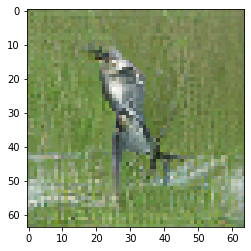

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 17

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.144110679626465 sec
Gen loss: 4.402987904664947, Gen valid loss: 1.2706593433369788, Gen attr loss: 1.5898075316979634, Gen caption loss: 1.5425210186459508, Disc valid loss: 1.099070986273489, Disc valid real loss: 0.5599965820629099, Disc valid fake loss: 0.5390744048566999, Disc attr loss: 3.0731831288273095, Disc attr real loss: 1.4833755971293463, Disc attr fake loss: 1.5898075316979634
Time for epoch 2 is 39.14637851715088 sec
Gen loss: 4.39197738642292, Gen valid loss: 1.2596975708718545, Gen attr loss: 1.5909075953449983, Gen caption loss: 1.5413722223059594, Disc valid loss: 1.0953325511317267, Disc valid real loss: 0.5595208348297491, Disc valid fake loss: 0.5358117203402325, Disc attr loss: 3.0742258647593057, Disc attr real loss: 1.4833182694143072, Disc attr fake loss: 1.5909075953449983
Time for epoch 3 is 39.248291015625 sec
Gen loss

Time for epoch 21 is 39.172443866729736 sec
Gen loss: 4.39905884401585, Gen valid loss: 1.2597288789787913, Gen attr loss: 1.5950512902200384, Gen caption loss: 1.5442786769169132, Disc valid loss: 1.0934054026112647, Disc valid real loss: 0.5612364597921449, Disc valid fake loss: 0.5321689424960594, Disc attr loss: 3.0772174499868377, Disc attr real loss: 1.4821661597667994, Disc attr fake loss: 1.5950512902200384
Time for epoch 22 is 39.1806058883667 sec
Gen loss: 4.405761483562025, Gen valid loss: 1.2667661911749903, Gen attr loss: 1.5945918941239354, Gen caption loss: 1.5444033869559848, Disc valid loss: 1.0909321744267533, Disc valid real loss: 0.5548087609654196, Disc valid fake loss: 0.5361234147535753, Disc attr loss: 3.0772847269931782, Disc attr real loss: 1.4826928328692428, Disc attr fake loss: 1.5945918941239354
Time for epoch 23 is 39.12464928627014 sec
Gen loss: 4.392100125470459, Gen valid loss: 1.251660128434499, Gen attr loss: 1.5954532788051823, Gen caption loss: 1.5

Time for epoch 41 is 39.139811515808105 sec
Gen loss: 4.407177583958076, Gen valid loss: 1.271486787130516, Gen attr loss: 1.5923310576415644, Gen caption loss: 1.5433597370861023, Disc valid loss: 1.0892046011560332, Disc valid real loss: 0.5514579770687796, Disc valid fake loss: 0.5377466215835354, Disc attr loss: 3.074112844337939, Disc attr real loss: 1.4817817866963745, Disc attr fake loss: 1.5923310576415644
Time for epoch 42 is 39.11898493766785 sec
Gen loss: 4.418821991943732, Gen valid loss: 1.2776738335769675, Gen attr loss: 1.5941161250034321, Gen caption loss: 1.5470320332018017, Disc valid loss: 1.0849477296599204, Disc valid real loss: 0.555935265168265, Disc valid fake loss: 0.5290124689337361, Disc attr loss: 3.0765377644923966, Disc attr real loss: 1.4824216394889644, Disc attr fake loss: 1.5941161250034321
Time for epoch 43 is 39.18809199333191 sec
Gen loss: 4.398308156305536, Gen valid loss: 1.2640340202222995, Gen attr loss: 1.5922181926122525, Gen caption loss: 1.5

Time for epoch 61 is 39.20720934867859 sec
Gen loss: 4.3895677848237, Gen valid loss: 1.2579755127268433, Gen attr loss: 1.5917876826392279, Gen caption loss: 1.5398045991494405, Disc valid loss: 1.0974731568075453, Disc valid real loss: 0.5605165487544, Disc valid fake loss: 0.5369566079723803, Disc attr loss: 3.0735230797997657, Disc attr real loss: 1.4817353971605378, Disc attr fake loss: 1.5917876826392279
Time for epoch 62 is 39.14549422264099 sec
Gen loss: 4.408883114817343, Gen valid loss: 1.2694148127302567, Gen attr loss: 1.5939024040692544, Gen caption loss: 1.545565892687335, Disc valid loss: 1.0867682267333756, Disc valid real loss: 0.5547368555534177, Disc valid fake loss: 0.5320313706146023, Disc attr loss: 3.0750255009669276, Disc attr real loss: 1.4811230968976732, Disc attr fake loss: 1.5939024040692544
Time for epoch 63 is 39.168663024902344 sec
Gen loss: 4.4140924670831945, Gen valid loss: 1.2762202234449103, Gen attr loss: 1.5932365390989516, Gen caption loss: 1.544

Time for epoch 81 is 39.131925106048584 sec
Gen loss: 4.400835564466027, Gen valid loss: 1.2560454374406396, Gen attr loss: 1.596805956951648, Gen caption loss: 1.5479841519823565, Disc valid loss: 1.1008845007193444, Disc valid real loss: 0.5624079591213527, Disc valid fake loss: 0.5384765411941663, Disc attr loss: 3.0770383763119455, Disc attr real loss: 1.4802324193602978, Disc attr fake loss: 1.596805956951648
Time for epoch 82 is 39.166051387786865 sec
Gen loss: 4.411696400422714, Gen valid loss: 1.266069502849889, Gen attr loss: 1.5996550693098446, Gen caption loss: 1.5459718093639467, Disc valid loss: 1.0858226271502693, Disc valid real loss: 0.5539189152278228, Disc valid fake loss: 0.5319037104686748, Disc attr loss: 3.0803046730475696, Disc attr real loss: 1.4806496037377253, Disc attr fake loss: 1.5996550693098446
Time for epoch 83 is 39.19450402259827 sec
Gen loss: 4.401054355187145, Gen valid loss: 1.2675985915227956, Gen attr loss: 1.591348022303284, Gen caption loss: 1.5

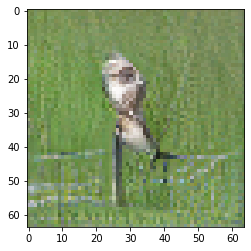

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 18

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.24784183502197 sec
Gen loss: 4.403277669172623, Gen valid loss: 1.263346046774691, Gen attr loss: 1.5953578212396886, Gen caption loss: 1.5445738061656797, Disc valid loss: 1.0946580812859987, Disc valid real loss: 0.5570254755537039, Disc valid fake loss: 0.5376326092859594, Disc attr loss: 3.075198900408861, Disc attr real loss: 1.4798410791691725, Disc attr fake loss: 1.5953578212396886
Time for epoch 2 is 39.42254877090454 sec
Gen loss: 4.407088699702648, Gen valid loss: 1.274267605165156, Gen attr loss: 1.5915894466363965, Gen caption loss: 1.5412316519393507, Disc valid loss: 1.0823019972338586, Disc valid real loss: 0.5508055805675383, Disc valid fake loss: 0.5314964169893808, Disc attr loss: 3.0715591009393295, Disc attr real loss: 1.479969654302933, Disc attr fake loss: 1.5915894466363965
Time for epoch 3 is 39.15453743934631 sec
Gen loss:

Time for epoch 21 is 39.12250733375549 sec
Gen loss: 4.408519560082495, Gen valid loss: 1.2750650490848676, Gen attr loss: 1.5920952532672623, Gen caption loss: 1.5413592685528887, Disc valid loss: 1.0943341402180473, Disc valid real loss: 0.5587315903446539, Disc valid fake loss: 0.5356025508425746, Disc attr loss: 3.070964584505655, Disc attr real loss: 1.4788693312383925, Disc attr fake loss: 1.5920952532672623
Time for epoch 22 is 39.127665519714355 sec
Gen loss: 4.404175819097173, Gen valid loss: 1.2641362053592031, Gen attr loss: 1.5951430739426031, Gen caption loss: 1.5448965373724133, Disc valid loss: 1.0908520024643358, Disc valid real loss: 0.555620093575015, Disc valid fake loss: 0.535231910666153, Disc attr loss: 3.074525716828137, Disc attr real loss: 1.4793826428855337, Disc attr fake loss: 1.5951430739426031
Time for epoch 23 is 39.13473153114319 sec
Gen loss: 4.408927079461778, Gen valid loss: 1.2646462461812709, Gen attr loss: 1.5964697754480006, Gen caption loss: 1.54

Time for epoch 41 is 39.16419053077698 sec
Gen loss: 4.414400944541787, Gen valid loss: 1.2704838436793506, Gen attr loss: 1.5979119416497911, Gen caption loss: 1.54600515533592, Disc valid loss: 1.093751245882453, Disc valid real loss: 0.5594456461548483, Disc valid fake loss: 0.5343055995660746, Disc attr loss: 3.0766780134139022, Disc attr real loss: 1.4787660717641111, Disc attr fake loss: 1.5979119416497911
Time for epoch 42 is 39.11978077888489 sec
Gen loss: 4.3995195649826755, Gen valid loss: 1.2610881436808, Gen attr loss: 1.59585963064416, Gen caption loss: 1.542571789527004, Disc valid loss: 1.0974715363365526, Disc valid real loss: 0.5608082941877164, Disc valid fake loss: 0.5366632422296013, Disc attr loss: 3.0742351026715946, Disc attr real loss: 1.478375472027435, Disc attr fake loss: 1.59585963064416
Time for epoch 43 is 39.09393572807312 sec
Gen loss: 4.412302281475325, Gen valid loss: 1.272320604582789, Gen attr loss: 1.5940647409537296, Gen caption loss: 1.54591695209

In [ ]:
next_starting_checkpoint, totalepochs, warmup = long_train(starting_checkpoint=next_starting_checkpoint, 
                                      num_checkpoints=60, 
                                      checkpoint_interval=100, 
                                      g_hist=gen_loss_hist, 
                                      g_valid_hist=gen_valid_loss_hist,
                                      g_attr_hist=gen_attr_loss_hist,
                                      g_caption_hist=gen_caption_loss_hist,
                                      d_hist=disc_loss_hist,
                                      d_real_hist=disc_loss_real_hist,
                                      d_fake_hist=disc_loss_fake_hist,
                                      d_attr_real_hist=disc_attr_loss_real_hist,
                                      d_attr_fake_hist=disc_attr_loss_fake_hist,
                                      noise=noise300,
                                      caption=caption,
                                      save_files=True,
                                      warmup=warmup)

In [ ]:
captions = train_captions[np.random.choice(range(len(train_captions)), 5, replace=False)]
# attrs = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
tempnoise = np.random.normal(0, 1, 300)
for i in range(5):
#     tempnoise = np.random.normal(0, 1, 300)

    
#     attrs[2] += 1.
    
    generated_image = generator.predict([np.array([tempnoise]), np.array([1.*captions[i]])] )[0][0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()
#     ax.imshow(unnormalize_img(generated_image))

In [ ]:
caption = bc.encode(['the medium sized bird has a dark grey color, a black downward curved beak, and long wings.'])[0]
noise = np.random.normal(0, 1, 300)
for i in range(1):
    generated_image = generator.predict([np.array([noise]), np.array([1.*caption])] )[0][0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()
#     ax.imshow(unnormalize_img(generated_image))

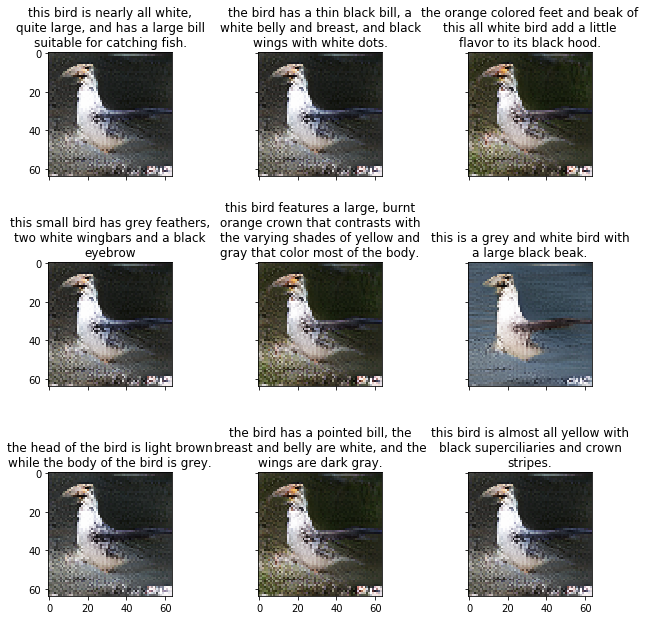

In [65]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=1.2,  # pad between axes in inch.
                 )

indices = np.random.choice(len(train_captions), 9)
captions = train_captions[indices]
text = [caption_text[x] for x in indices]
tempnoise = np.random.normal(0, 1, 300)
for i, ax in enumerate(grid):
    generated_image = generator.predict([np.array([tempnoise]), np.array([captions[i]])] )[0][0]
    ax.imshow(unnormalize_img(generated_image))
    ax.set_title('\n'.join(wrap(text[i], 35)))

In [ ]:
plot_save_dir = 'bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34'

from operator import add
disc_attr_loss_hist = list( map(add, disc_attr_loss_real_hist, disc_attr_loss_fake_hist) )

plt.plot(gen_loss_hist)
plt.plot(disc_loss_hist)
plt.plot(disc_attr_loss_hist)

plt.legend(['Gen Loss','Disc Valid Loss', 'Disc Attr Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_d_losses.png')
plt.show()

plt.plot(gen_valid_loss_hist)
plt.plot(gen_attr_loss_hist)
plt.plot(gen_caption_loss_hist)
plt.legend(['Gen Valid Loss', 'Gen Attr Loss', 'Gen Caption Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_valid_attr_losses.png')
plt.show()

plt.plot(gen_loss_hist - np.mean(gen_loss_hist))
plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
plt.plot(disc_attr_loss_hist - np.mean(disc_attr_loss_hist))
plt.legend(['Gen Loss Normalized','Disc Valid Loss Normalized', 'Disc Attr Loss Normalized'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_d_losses_normalized.png')
plt.show()

plt.plot(disc_loss_real_hist)
plt.plot(disc_loss_fake_hist)
plt.legend(['Disc Real Loss','Disc Fake Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/d_real_fake_losses.png')
plt.show()

plt.plot(disc_attr_loss_real_hist)
# plt.show()
plt.plot(disc_attr_loss_fake_hist)
plt.legend(['Disc Attribute Real Loss', 'Disc Attribute Fake Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/d_attribute_real_fake_losses.png')
plt.show()


In [ ]:
prediction = discriminator_attr.predict(np.array([train_imgs[6]]))[0]
print(np.where(np.round(prediction) == 1))

In [ ]:
prediction = discriminator_attr.predict(np.array([train_imgs[344]]))[0]
print(np.where(np.round(prediction) == 1))

In [ ]:
d = dict.fromkeys([i for i in range(10)], 0)
prediction = discriminator_attr.predict(np.array(train_imgs))
prediction = np.round(prediction)
for p in prediction:
    p = np.where(p == 1)
    for i in p[0]:
        d[i] += 1
    
# for im in train_imgs:
#     for p in prediction[0]:
#         d[p] += 1

In [ ]:
plt.bar([x for x in range(10)], d.values())

In [ ]:
plt.bar([x for x in range(10)], np.sum(train_attrs, axis=0))

In [ ]:
train_captions[0]

In [ ]:
from bert_serving.client import BertClient
bc = BertClient()

In [ ]:
testcaption = bc.encode(['red bird.'])[0]

In [ ]:
testcaption[0][0]


In [58]:
def save_plots(epochs):
    plt.ioff()
    plot_save_dir = 'bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34'

    from operator import add
    disc_attr_loss_hist = list( map(add, disc_attr_loss_real_hist, disc_attr_loss_fake_hist) )
    
    fig = plt.figure()
    plt.plot(gen_loss_hist)
    plt.plot(disc_loss_hist)
    plt.plot(disc_attr_loss_hist)

    plt.legend(['Gen Loss','Disc Valid Loss', 'Disc Attr Loss'])
    plt.savefig('./results/plots/'+plot_save_dir+'/g_d_losses' + str(epochs) + '.png')
    plt.close(fig)
#     plt.show()

    fig = plt.figure()
    plt.plot(gen_valid_loss_hist)
    plt.plot(gen_attr_loss_hist)
    plt.plot(gen_caption_loss_hist)
    plt.legend(['Gen Valid Loss', 'Gen Attr Loss', 'Gen Caption Loss'])
    plt.savefig('./results/plots/'+plot_save_dir+'/g_valid_attr_losses' + str(epochs) + '.png')
    plt.close(fig)
#     plt.show()

    fig = plt.figure()
    plt.plot(gen_loss_hist - np.mean(gen_loss_hist))
    plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
    plt.plot(disc_attr_loss_hist - np.mean(disc_attr_loss_hist))
    plt.legend(['Gen Loss Normalized','Disc Valid Loss Normalized', 'Disc Attr Loss Normalized'])
    plt.savefig('./results/plots/'+plot_save_dir+'/g_d_losses_normalized' + str(epochs) + '.png')
    plt.close(fig)
#     plt.show()

    fig = plt.figure()
    plt.plot(disc_loss_real_hist)
    plt.plot(disc_loss_fake_hist)
    plt.legend(['Disc Real Loss','Disc Fake Loss'])
    plt.savefig('./results/plots/'+plot_save_dir+'/d_real_fake_losses' + str(epochs) + '.png')
    plt.close(fig)
#     plt.show()

    fig = plt.figure()
    plt.plot(disc_attr_loss_real_hist)
    # plt.show()
    plt.plot(disc_attr_loss_fake_hist)
    plt.legend(['Disc Attribute Real Loss', 'Disc Attribute Fake Loss'])
    plt.savefig('./results/plots/'+plot_save_dir+'/d_attribute_real_fake_losses' + str(epochs) + '.png')
    plt.close(fig)
#     plt.show()
    plt.ion()

In [59]:
save_plots(1)